# Исследование предстоящих релизов компьютерных игр

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков». 

**Откроем файл с данными и изучим общую информацию**

In [1]:
import pandas as pd             # импортируем библиотеку пандас
import matplotlib.pyplot as plt # импортируем библиотеку матплотлиб 
import seaborn as sns           # импортируем библиотеку сиаборн
import warnings
warnings.filterwarnings("ignore")
# предотвратим будущее появление предупреждений

**Заранее улчшим качество графиков и изменим параметры по умолчанию**

In [2]:
%config InlineBackend.figure_format = 'retina' # устанавливаем конфиг, повыщающий разрешение графиков
plt.style.use('bmh')
from pylab import rcParams
rcParams['figure.figsize'] = 14,6

In [3]:
df = pd.read_csv('/Users/whyyoutried/Downloads/games.csv') # читаем файл с данными
df.head(5) # выводим первые 5 строк нашего дата фрейма

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info() # выведем общую информацию про наш дата фрейм

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Комментарий к выводу**

- необходимо привести названия столбцов к нижнему регистру
- проверить данные на наличие дубликатов (явных и неявных)
- для столбцов 'User_Score' необходимо поменять тип данных на float16
- для столбцов 'Name', 'Platform', 'Genre' и 'Rating' необходимо поменять тип данных на str, поскольку, если мы уверены, что в этих столбцах у нас только слова, то строковый тип данных будет более оптимален с точки зрения затрат памяти 
- а для всех остальных столбцов с целью оптимизации использования памяти можно поменять тип данных на float16, кроме столбца 'year_of_release' для него тип данных подойдет int8
- есть пропуски, необходимо посмотреть а сколько их всего и в каких столбцах, поскольку это может повлиять на наши дальнейшие действия

## Предобработка данных


In [5]:
df['Rating'].unique()
# посмотрим уникальные значения в столбце 'Rating' для определения какой тип данных подойдет для данного столбца

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [6]:
df.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales',\
             'critic_score', 'user_score', 'rating'] # приводим названия столбцов в нижний регистр

**Комментарий перед сменой типов данных**

- поскольку у нас есть столбцы с пропусками, то их тип данных не получится сменить на float, для успешной смены типов данных необходимо заполнить 0 данные пропуски, однако предварительно необходимо убедиться, что значения "0" в этих столбцах не было

In [7]:
df = df.dropna(subset='year_of_release') # удалим 269 пропуска, игры без известной даты выхода
df.isna().sum() # посмотрим сколько осталось пропусков

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         6607
rating             6678
dtype: int64

**Комментарий к выводу**

- поскольку неизвестный год релиза игры мы не можем заполнить подходящими данными, то лучше от таких строк избавиться, более того, количетсво таких данных составило порядка 2% от всего дата фрейма, так что удаление этих данных было не столь критично
- большинство оставшихся пропусков - в столбцах с оценками - их можно будет заполнить медианными значениями, а пока что приведем названия столбцов к нижнему регистру и построим гистограммы наших "сырых" данных

**Далее будем работать с явными и неявными дубликатами**

In [8]:
df.duplicated().sum()
# проверим дата фрейм на наличие явных дубликатов

0

In [9]:
df[df.duplicated(subset=['name', 'platform'])]
# выведем список игр, вышедших на одной и той же платформе (это важное уточнение, поскольку игра выходит сразу на 
# несколько платформ, и если смотреть дубликаты только по названию - то половина строк будет дубликатами, что неверно)
# которые продублировались в дата фрейме по какой-либо причине
# были выбраны столбцы 'name' и 'platform', потому, что 
# во всех остальных столбцах информация может повторяться и это будет адекватно

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


In [10]:
df.query('name == "Need for Speed: Most Wanted"').sort_values('platform')
# посмотрим на примере игры "Need for Speed: Most Wanted"

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E
6473,Need for Speed: Most Wanted,GBA,2005.0,Racing,0.19,0.07,0.00,0.00,NaN,8.3,E
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T


**Комментарий к выводу**

- игра "Need for Speed: Most Wanted" имеет 2 строки с неправильной датой релиза (для PC и X360)
- их и нужно удалить

In [11]:
df.query('name == "Madden NFL 13"').sort_values('platform')
# проверим так же игру "Madden NFL 13"

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E


**А теперь удалим подобные неявные дубликаты**

In [12]:
df = df.drop_duplicates(subset=['name', 'platform'], keep='first')
# удалим неявные дубликаты 

In [13]:
df.duplicated(subset=['name', 'platform']).sum()
# проверим, что все неявные дубликаты удалились

0

**Комментарий к выводу**

- явных дубликатов в дата фрейме не оказалось
- а вот неявных было 4 - 2 для игры "Need for Speed: Most Wanted" (для разных платформ) и по 1 для игры "Madden NFL 13" и старенькой игры - 1993 года - без названия на платформе "GEN"
- 
**Далее будем работать со столбцами 'critic_score' и 'user_score'**

In [14]:
df['critic_score'].unique()
# посмотрим какие есть значения в столбце "critic_score"

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [15]:
df['user_score'].unique()
# посмотрим какие есть значения в столбце "user_score"

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**Комментарий к выводу**

- поскольку оценка критика или юзера может быть 0, то при замене пропусков в данных столбцах на 0 мы можем исказить данные, например, при подсчете медианной или средней оценки
- поэтому пропуски в данных столбцах лучше оставить, ведь пропуски тоже важная часть информации, по ним, например, можно узнать насколько часто осталвяют оценки пользователи и критик

**Возможно, чем позже вышла игра, тем больше вероятность того, что оценка у нее есть и от критика, и от пользователей, ведь с развитием любой индустрии, гейм-дев в том числе, получение обратной связи от своих пользователей и внешнего окружения компании становится важнее и важнее, поскольку именно в этих диалогах можно узнать свои точки роста \
Далее мы как раз и проверим это \
Но прежде мы поменяем тип данных в столбцах**

In [16]:
df = df.astype({'name' : 'str', 'platform' : 'str', 'genre' : 'str', 'year_of_release' : 'int16',\
                'na_sales' : np.float16, 'eu_sales' : np.float16, 'jp_sales' : np.float16,\
                'other_sales' : np.float16, 'critic_score' : np.float16})
# меняем тип данных столбцов 
df.info() # смотрим информацию по дата фрейму

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  int16  
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float16
 5   eu_sales         16442 non-null  float16
 6   jp_sales         16442 non-null  float16
 7   other_sales      16442 non-null  float16
 8   critic_score     7980 non-null   float16
 9   user_score       9836 non-null   object 
 10  rating           9765 non-null   object 
dtypes: float16(5), int16(1), object(5)
memory usage: 963.4+ KB


**Комментарий к работе по смене типов данных в столбцах**

- столбцы 'name', 'platform' и 'genre' приведены к строковому типу данных
- столбец 'year_of_release' имеет тип данных int8
- столбец 'rating' остался без изменений
- все остальные столбцы за исключением 'user_score' приведены к типу float16, в случае с 'user_score' появлялась ошибка, с которой мы будем работать отдельно далее

**А теперь проверим вышевысказанную гипотезу**

In [17]:
years = df[df['year_of_release'] > 2001]['year_of_release'].unique()
# создадим список с годами для итерирования по нему
# пояснение почему был выбран именно такой временной интервал будет далее, в начале исследовательского анализа

In [18]:
for i in enumerate(sorted(years)):
    print(f'в {i[1]} году \033[1m{df[df["year_of_release"] == i[1]]["user_score"].isna().sum()}\033[0m игр(-ы, -а) осталось без оценки пользователей, что соствляет \033[1m{round(df[df["year_of_release"] == i[1]]["user_score"].isna().sum() / df[df["year_of_release"] == i[1]]["name"].count() * 100, 2)}%\033[0m игр, вышедших в этом году')
# посмотрим количество игр оставшихся без оценки критиков в каждый из годов в рассматриваемом периоде,
# а также какова доля таких игр в этом году

в 2002 году 173 игр(-ы, -а) осталось без оценки пользователей, что соствляет 20.87% игр, вышедших в этом году
в 2003 году 164 игр(-ы, -а) осталось без оценки пользователей, что соствляет 21.16% игр, вышедших в этом году
в 2004 году 166 игр(-ы, -а) осталось без оценки пользователей, что соствляет 21.78% игр, вышедших в этом году
в 2005 году 235 игр(-ы, -а) осталось без оценки пользователей, что соствляет 25.05% игр, вышедших в этом году
в 2006 году 330 игр(-ы, -а) осталось без оценки пользователей, что соствляет 32.8% игр, вышедших в этом году
в 2007 году 376 игр(-ы, -а) осталось без оценки пользователей, что соствляет 31.41% игр, вышедших в этом году
в 2008 году 440 игр(-ы, -а) осталось без оценки пользователей, что соствляет 30.83% игр, вышедших в этом году
в 2009 году 407 игр(-ы, -а) осталось без оценки пользователей, что соствляет 28.54% игр, вышедших в этом году
в 2010 году 457 игр(-ы, -а) осталось без оценки пользователей, что соствляет 36.41% игр, вышедших в этом году
в 2011 году

In [19]:
for i in enumerate(sorted(years)):
    print(f'в {i[1]} году \033[1m{df[df["year_of_release"] == i[1]]["critic_score"].isna().sum()}\033[0m игры(-ы, -а) осталось без оценки критиков, что соствляет \033[1m{round(df[df["year_of_release"] == i[1]]["critic_score"].isna().sum() / df[df["year_of_release"] == i[1]]["name"].count() * 100, 2)}%\033[0m игр, вышедших в этом году')
yearx = df[df['year_of_release'] > 2001]['year_of_release'].unique()
# посмотрим количество игр оставшихся без оценки пользователей в каждый из годов в рассматриваемом периоде,
# а также какова доля таких игр в этом году

в 2002 году 202 игры(-ы, -а) осталось без оценки критиков, что соствляет 24.37% игр, вышедших в этом году
в 2003 году 190 игры(-ы, -а) осталось без оценки критиков, что соствляет 24.52% игр, вышедших в этом году
в 2004 году 201 игры(-ы, -а) осталось без оценки критиков, что соствляет 26.38% игр, вышедших в этом году
в 2005 году 284 игры(-ы, -а) осталось без оценки критиков, что соствляет 30.28% игр, вышедших в этом году
в 2006 году 386 игры(-ы, -а) осталось без оценки критиков, что соствляет 38.37% игр, вышедших в этом году
в 2007 году 505 игры(-ы, -а) осталось без оценки критиков, что соствляет 42.19% игр, вышедших в этом году
в 2008 году 712 игры(-ы, -а) осталось без оценки критиков, что соствляет 49.89% игр, вышедших в этом году
в 2009 году 775 игры(-ы, -а) осталось без оценки критиков, что соствляет 54.35% игр, вышедших в этом году
в 2010 году 755 игры(-ы, -а) осталось без оценки критиков, что соствляет 60.16% игр, вышедших в этом году
в 2011 году 636 игры(-ы, -а) осталось без оцен

**Комментарий к полученной информации по пропускам**

- казалось бы, относительная доля пропусков в столбцах с оценкам с каждым годом должна уменьшаться, однако в нашем случае мы можем наблюдать совершенно обратную ситуацию, возможно, просто конкретно в этом дата фрейме отсутсвует информация об оценках пользователей, однако это заставляет задуматься о достовернности данных в целом

**Но имеем то, что имеем, продолжаем работу и переходим к построению гистограмм**

array([[<AxesSubplot:title={'center':'year_of_release'}>,
        <AxesSubplot:title={'center':'na_sales'}>],
       [<AxesSubplot:title={'center':'eu_sales'}>,
        <AxesSubplot:title={'center':'jp_sales'}>],
       [<AxesSubplot:title={'center':'other_sales'}>,
        <AxesSubplot:title={'center':'critic_score'}>]], dtype=object)

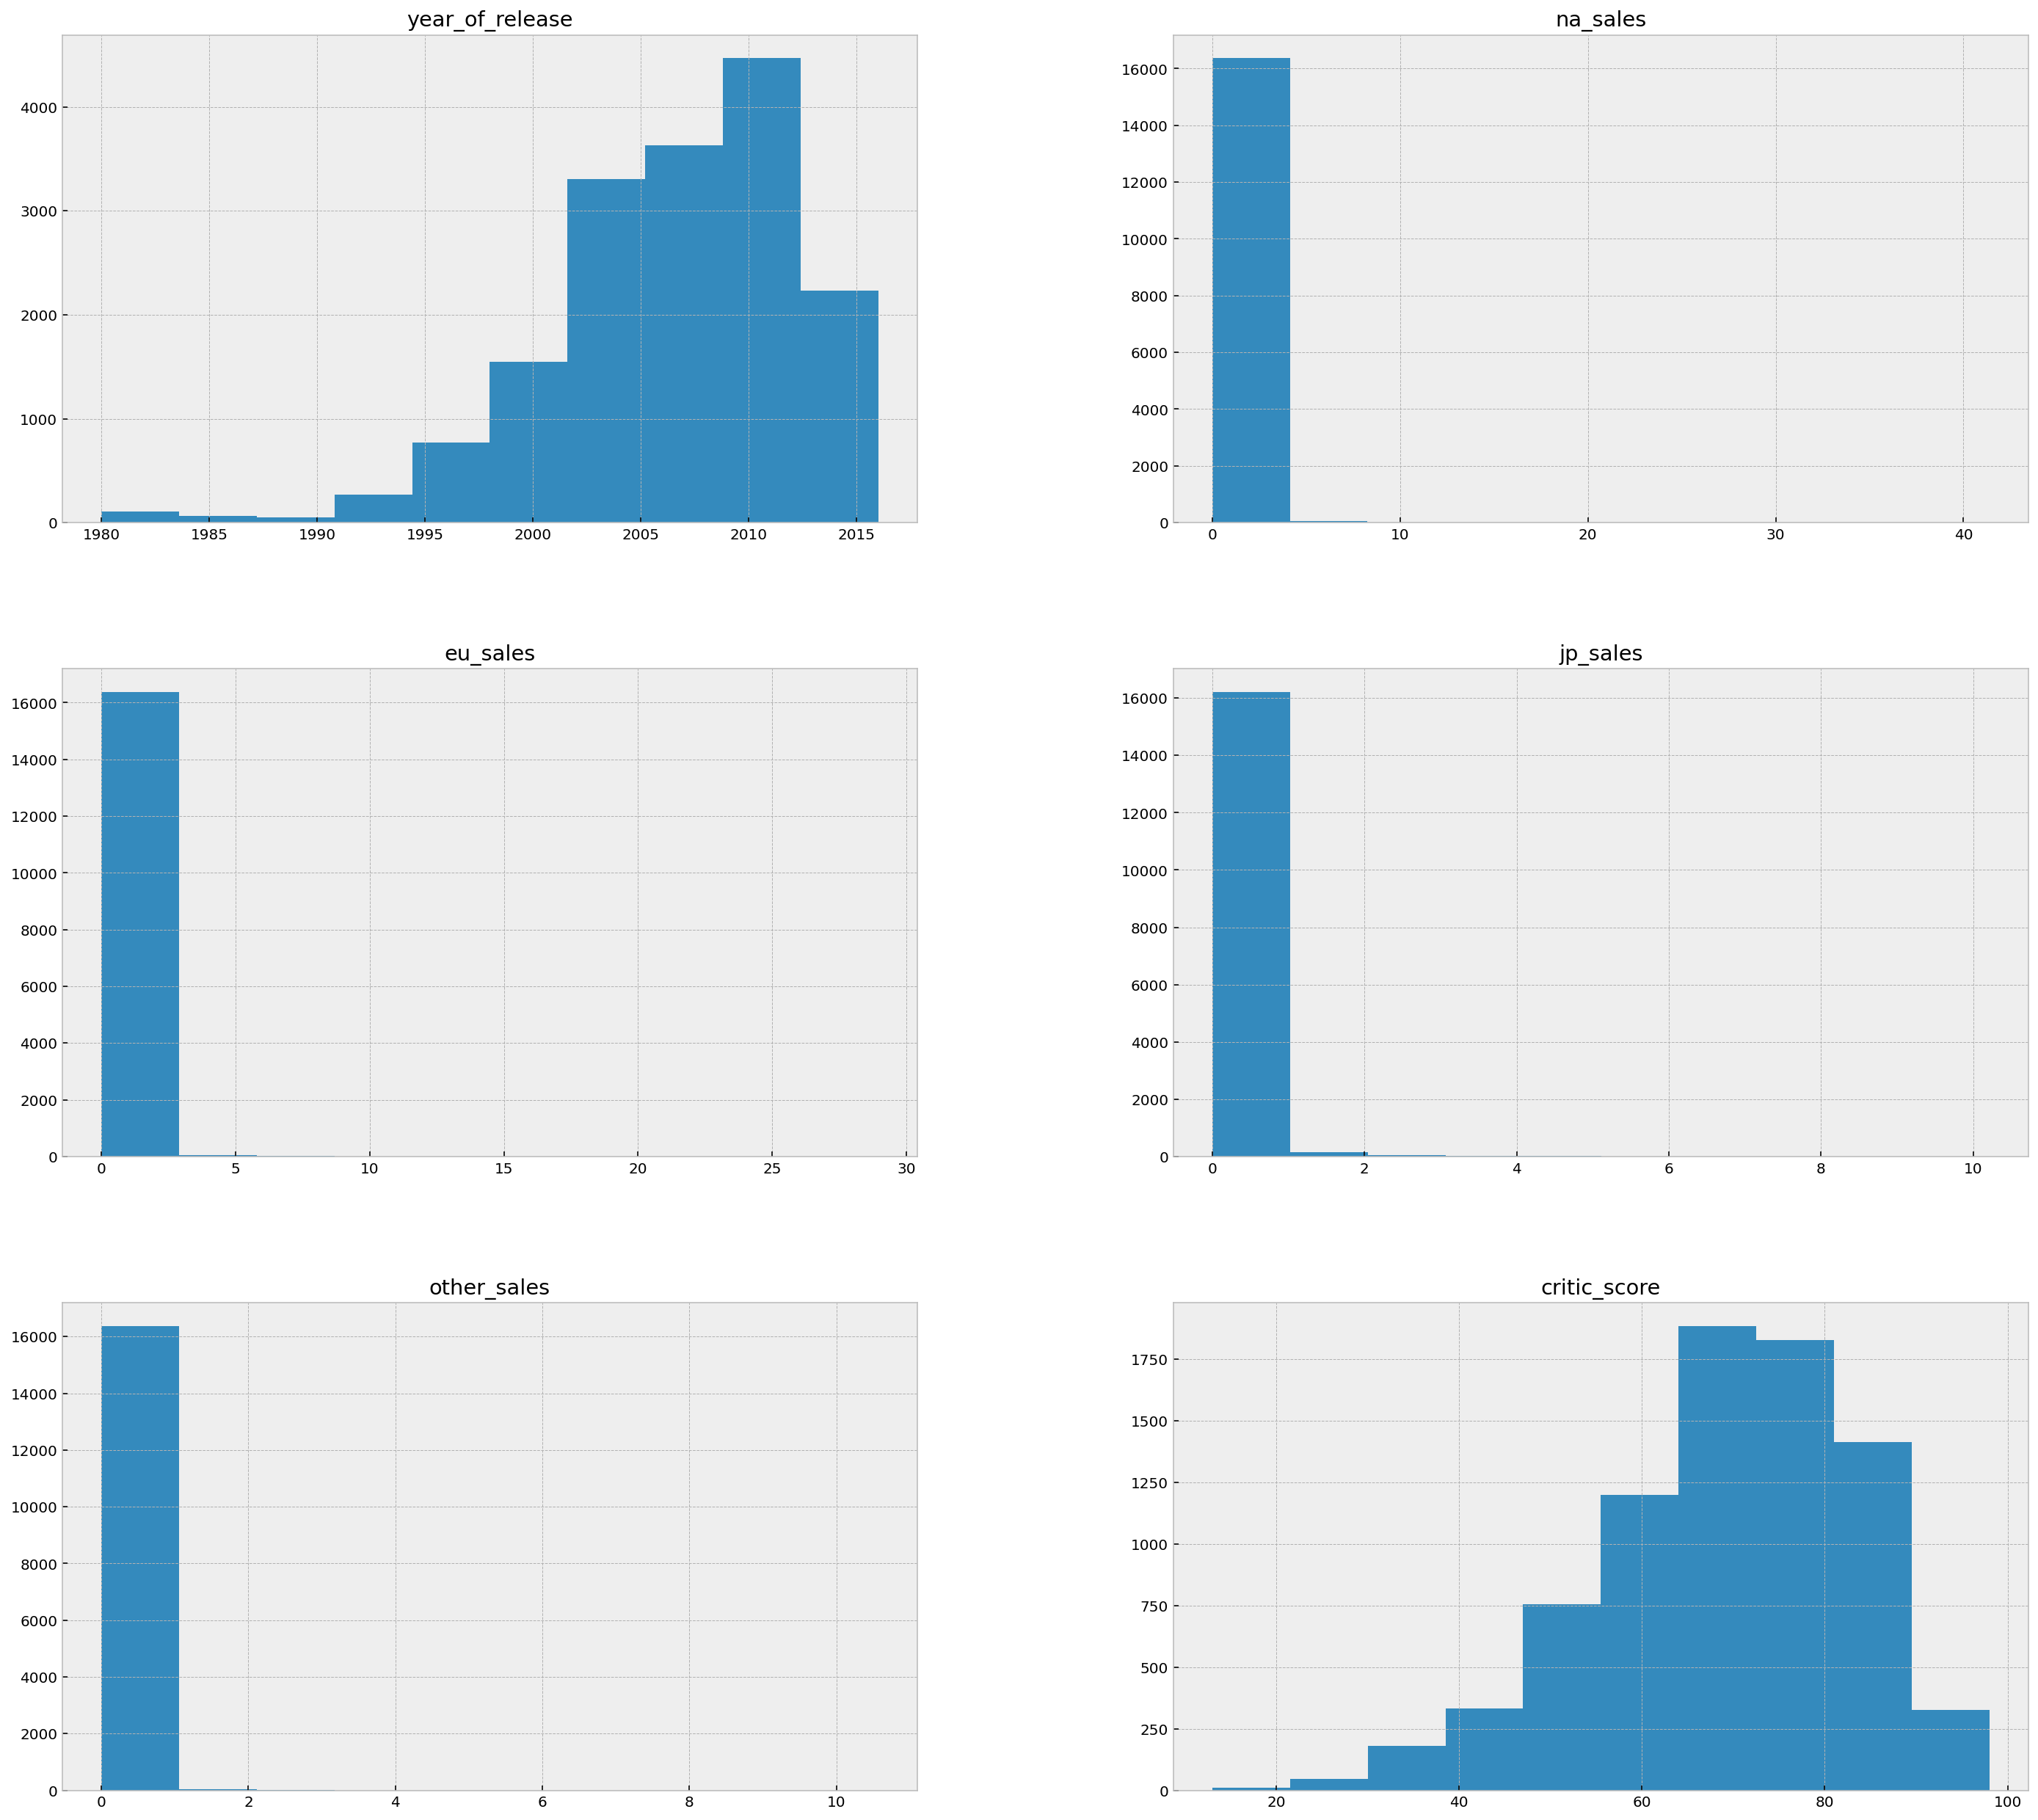

In [20]:
df.hist(figsize=(24, 22))
# строим гистограммы для всех столбцов дата фрейма

**Комментарий к полученным гистограммам**

- на всех графиках, кроме гистограмм по столбцам "Year_of_Release" и "Critic_Score", есть выбросы, которые делают график нечитаемым, с ними мы поработаем далее, а пока что займемся обработкой пропусков

**Далее будем работать со столбцом 'Name'**

In [21]:
df = df.dropna(subset='name') # удалим 2 пропуска, игры без названия
df.isna().sum() # посмотрим сколько осталось пропусков

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8462
user_score         6606
rating             6677
dtype: int64

In [22]:
df.reset_index(inplace=True)

**Комментарий к выводу**

- ожидаемо, после удаления 2 пропусков из столбца 'name' пропуски в столбце 'genre' тоже исчезли

**Далее будем работать со столбцом 'rating'**

In [23]:
df.isna().sum() # посмотрим сколько осталось пропусков

index                 0
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8462
user_score         6606
rating             6677
dtype: int64

In [24]:
df['rating'].unique() # выведем уникальные значения столбца 'rating'

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [25]:
df = df.replace(to_replace='K-A', value='E')
# заменим значение 'K-A' - kid to adults - на 'E' - everuone - поскольку 'E' является более современным термином 

In [26]:
df['rating'].unique() # проверим уникальные значения столбца 'rating'

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

**Комментарий к выводу**

- в нашем списке уникальных значений столбца 'rating' осталась оценка 'RP', означающая, что рейтинг ожидается, поэтому данное значение лучше заменить на пропуск
- пропуски лучше оставить без изменений, поскольку ни по жанру игры, ни по платформе нельзя сказать, какую возрастную категорию присвоят той или иной игре 
- ссылка на источник, из которого бралась информация про названия возрастных категорий и их значения

https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board

**Далее будем работать со значением 'RP'**

In [27]:
df[df['rating'] == 'RP'] # проверим сколько строк имеет значение 'RP' в столбце 'rating'

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14044,14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.0,0.029999,0.0,0.010002,63.0,6.8,RP


**Комментарий к выводу**

- всего 1 строка, смело можно заменить на пропуск
- а тип данных данного столбца привести к строковому типу

In [28]:
df = df.replace(to_replace='RP', value=None) # заменим значение 'RP' на None

In [29]:
df.isna().sum() # проверим количество пропусков

index                 0
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8462
user_score         6606
rating             6678
dtype: int64

**Комментарий к выводу**

- количество пропусков увеличлось ровно на 1 значение, а значит все заменилось верно

**Далее будем работать со значением 'nan' в столбце 'rating'**

In [30]:
df['rating'].unique() # проверим уникальные значения столбца 'rating'

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'EC', None], dtype=object)

In [31]:
df['rating'] = df['rating'].fillna('None') # заполним пропуски в столбце 'rating' на значение 'None'

In [32]:
df['rating'].unique() # проверим уникальные значения столбца 'rating'

array(['E', 'None', 'M', 'T', 'E10+', 'AO', 'EC'], dtype=object)

In [33]:
df['rating'] = df['rating'].astype(str) # меняем тип данных на строковый

**Далее будем работать со значением 'tbd' в столбце 'user_score'**

In [34]:
df[df['user_score'] == 'tbd'] # посмотрим сколько всего строк с оценкой пользователя, которая еще не опубликована

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,119,Zumba Fitness,Wii,2010,Sports,3.449219,2.589844,0.0,0.660156,NaN,tbd,E
300,301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.080078,1.349609,0.0,0.540039,61.0,tbd,E10+
516,520,Zumba Fitness 2,Wii,2011,Sports,1.509766,1.030273,0.0,0.270020,NaN,tbd,T
639,645,uDraw Studio,Wii,2010,Misc,1.650391,0.569824,0.0,0.199951,71.0,tbd,E
710,718,Just Dance Kids,Wii,2010,Misc,1.519531,0.540039,0.0,0.180054,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...,...
16422,16695,Planet Monsters,GBA,2001,Action,0.010002,0.000000,0.0,0.000000,67.0,tbd,E
16424,16697,Bust-A-Move 3000,GC,2003,Puzzle,0.010002,0.000000,0.0,0.000000,53.0,tbd,E
16425,16698,Mega Brain Boost,DS,2008,Puzzle,0.010002,0.000000,0.0,0.000000,48.0,tbd,E
16431,16704,Plushees,DS,2008,Simulation,0.010002,0.000000,0.0,0.000000,NaN,tbd,E


**Комментарий к выводу**

- таких строк оказалось довольно таки много - 2376 строки - однако подходящего значения для замены этого значения у нас нет, поэтому лучше заменить его на None, что сообщит нам, что есть игры, у которых оценка пользователей пока что неизвестна

In [35]:
df = df.replace(to_replace='tbd', value='NaN') # заменим значение 'tbd' на None

In [36]:
df['user_score'].unique() # проверим уникальные значения столбца 'user_score'

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'NaN', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [37]:
df['user_score'] = df['user_score'].astype('float16') # меняем тип данных на float

**По условию ТЗ необходимо добавить столбец с суммарными продажами, далее этим мы и займемся**

In [38]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
# считаем общие продажы игры (axis=1 - по строкам)

In [39]:
df.head() # посмотрим на новый столбец

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.375000,28.953125,3.769531,8.453125,76.0,8.000000,E,82.500
1,1,Super Mario Bros.,NES,1985,Platform,29.078125,3.580078,6.808594,0.770020,NaN,NaN,None,40.250
2,2,Mario Kart Wii,Wii,2008,Racing,15.679688,12.757812,3.789062,3.289062,82.0,8.296875,E,35.500
3,3,Wii Sports Resort,Wii,2009,Sports,15.609375,10.929688,3.279297,2.949219,80.0,8.000000,E,32.750
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.273438,8.890625,10.218750,1.000000,NaN,NaN,None,31.375


### Итоги предобработки данных

Подводя итог этапу предобработки данных, стоит отметить следующие моменты:

- названия столбцов приведены к нижнему регистру
- тип данных в столбцах: 'name', 'platform', 'genre' и 'rating' - приведен к "str"
- в остальных столбцах к "float16", кроме столбца 'year_of_release' в нем тип данных - "int8"
- удалены 2 строки с пропуском в столбцах 'name' и 'genre'
- дата фрейм проверен на наличие явных дубликатов
- а также удалены 4 неявных дубликата
- в столбце 'rating' пропуски заполнены None
- в стобцах 'user_score' и 'critic_score' пропуски заполнены значением "0" - то есть теперь пропуски - это "0"
- а также в столбце 'user_score' значение "tbd" заменено на NaN
- добавлен столбец с суммарными продажами игры

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16442 entries, 0 to 16441
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16442 non-null  int64  
 1   name             16442 non-null  object 
 2   platform         16442 non-null  object 
 3   year_of_release  16442 non-null  int16  
 4   genre            16442 non-null  object 
 5   na_sales         16442 non-null  float16
 6   eu_sales         16442 non-null  float16
 7   jp_sales         16442 non-null  float16
 8   other_sales      16442 non-null  float16
 9   critic_score     7980 non-null   float16
 10  user_score       7460 non-null   float16
 11  rating           16442 non-null  object 
 12  total_sales      16442 non-null  float16
dtypes: float16(7), int16(1), int64(1), object(4)
memory usage: 899.3+ KB


## Исследовательский анализ данных

**Для начала изучим количество выпускаемых игр по годам**

[Text(0.5, 1.0, 'Количество выпущенных игр по годам')]

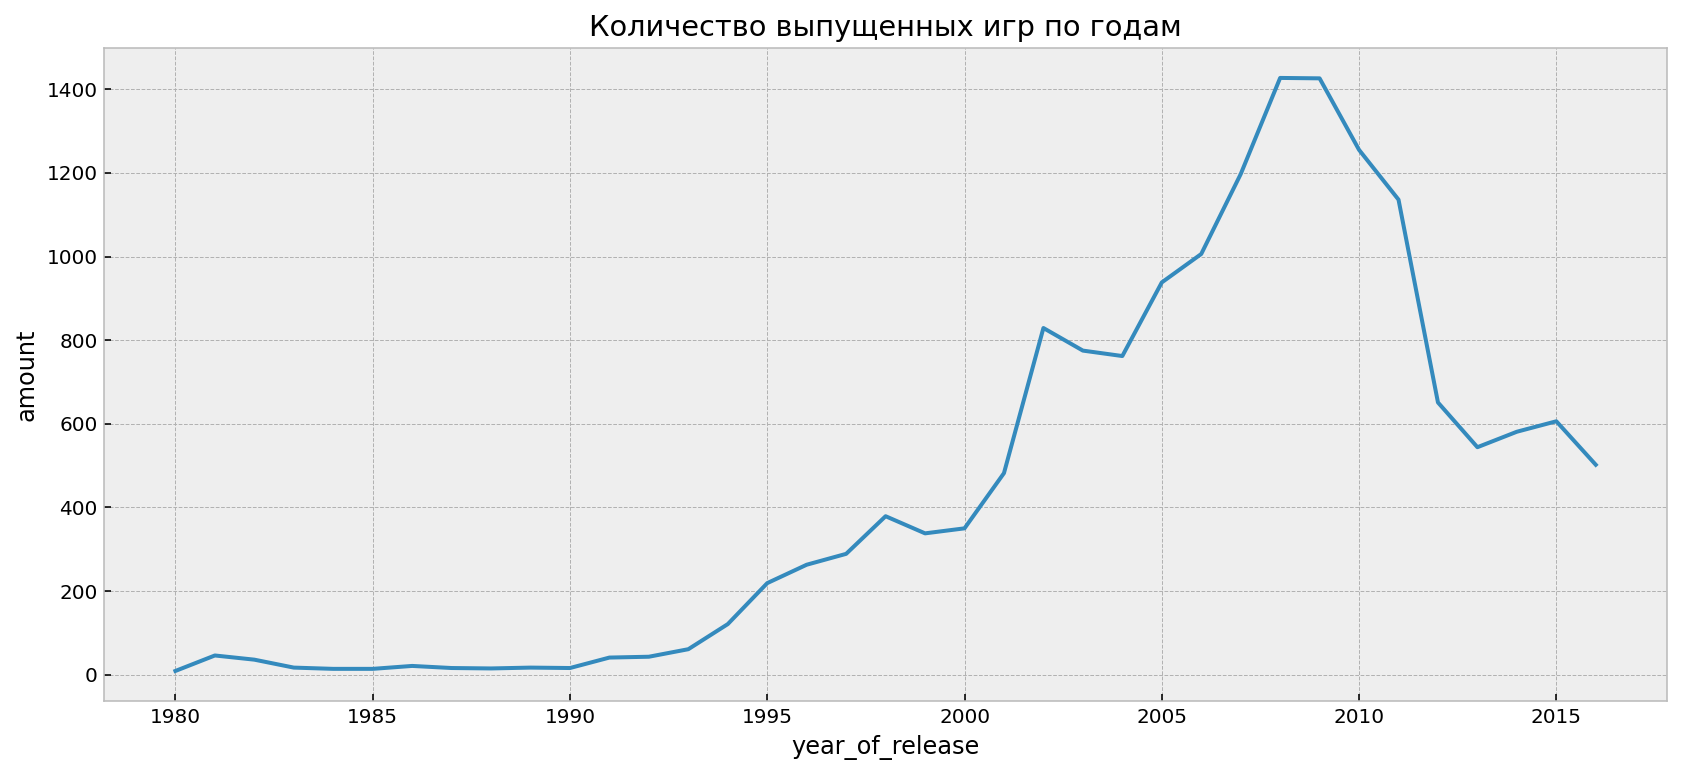

In [41]:
year_gb = df.groupby('year_of_release', as_index=False).agg({'genre' : 'count'}).rename(columns={'genre': 'amount'})
# сгруппируем таблицу по годам и посчитаем количество игр, выпущенных в каждому году
sns.lineplot(x ='year_of_release', y ='amount', data = year_gb).set(title='Количество выпущенных игр по годам')

**Комментарий к полученному графику:**

- можно увидеть, что рост количества выпускаемых игр начался примерно с 1993 года, однако до 2000-ых годов доступность цифровых устройств была не столь высокая, поэтому резкий рост в начале 2000-ых можно обусловить появлением какого-то бюджетного устройства

**Далее определим с какого именно года началася бурный рост**

[Text(0.5, 1.0, 'Количество выпущенных игр по годам')]

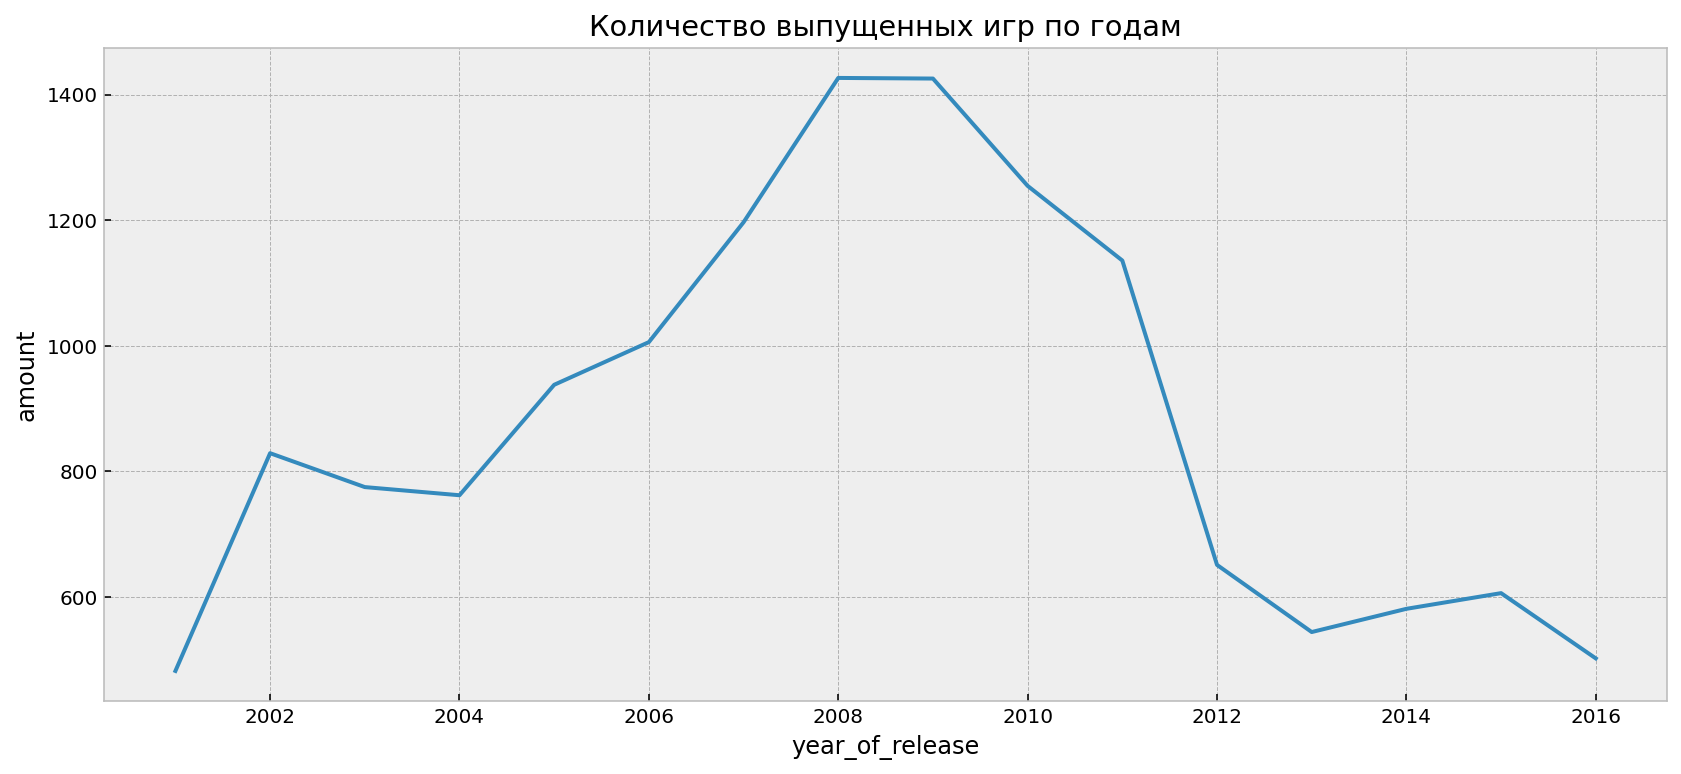

In [42]:
sns.lineplot(x ='year_of_release', y ='amount', data = year_gb.query('year_of_release > 2000')).\
set(title='Количество выпущенных игр по годам')
# посмотрим в каком именно году произошел резкий рост в начале 2000-ых

**Комментарий к полученному графику:**

- по графику хорошо видно, что рост произошел в 2002 году, с этого года мы и будем изучать данные, поскольку до 2002 года объем информации по выпускаемым играм за год был не слишком обширный, а также игры прошлого века сильно отличаются по сравнению с теми же играми начала 2000-ых 

**Далее будем работать с информацией от 2002 года и позже**

[Text(0.5, 1.0, 'Количество выпущенных игр по годам')]

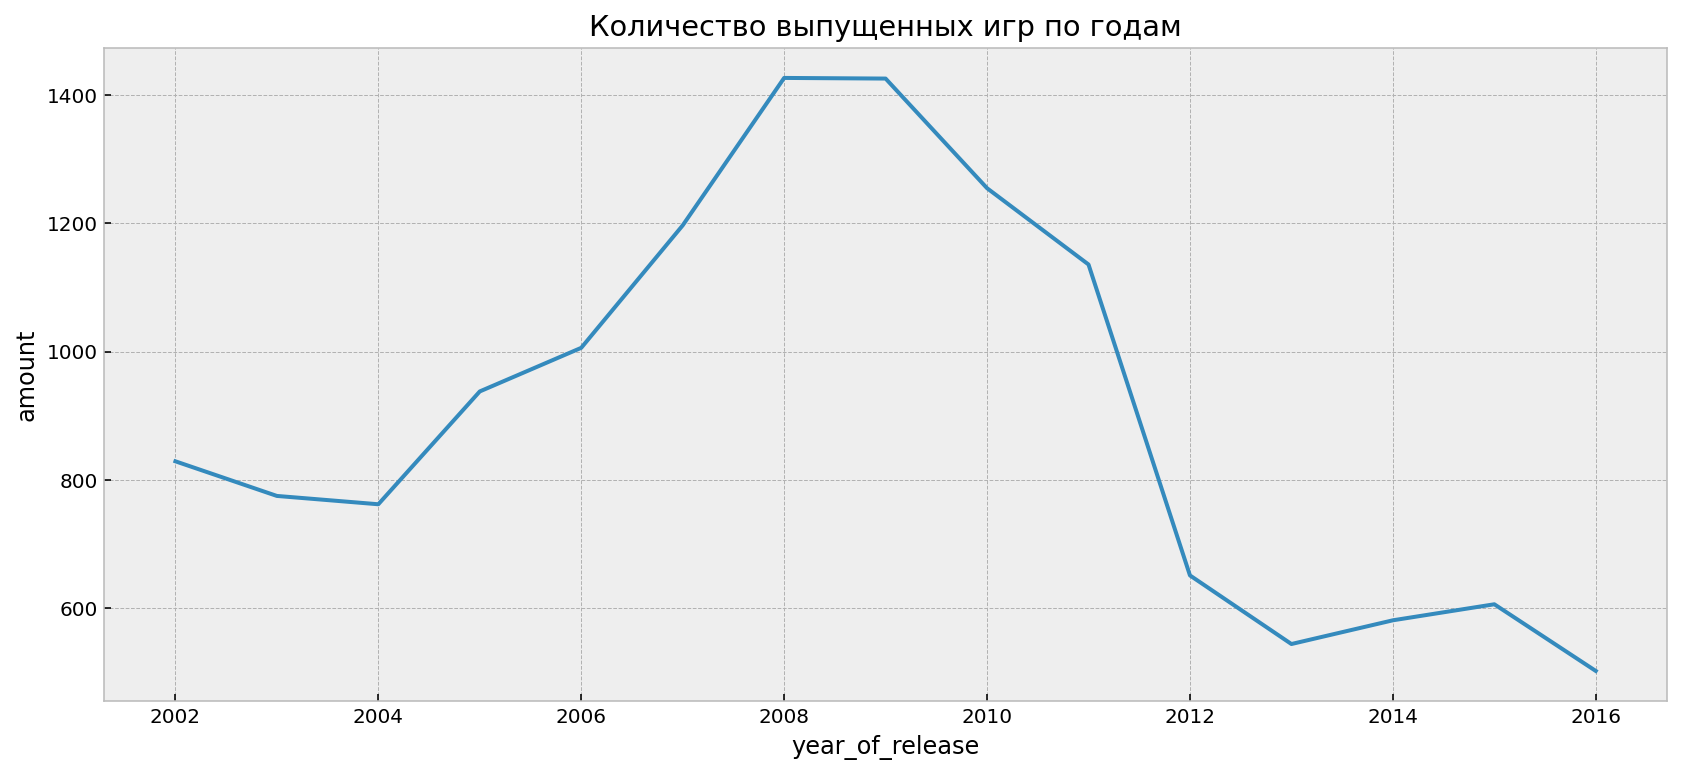

In [43]:
sns.lineplot(x ='year_of_release', y ='amount', data = year_gb.query('year_of_release > 2001')).\
set(title='Количество выпущенных игр по годам')
# посмотрим на график количества вышедших игр с 2002 года

**Комментарий к полученному графику:**

- после вышеописанного пика в 2002 году наблюдался небольшой спад в 2003 году, который может быть связан с тем, что студии разработки игр прост не успели ввыпустить свои игры в 2003 или же просто и не собирались это делать, поскольку годом ранее вышло непривычно огромнное количество игр, а вот с 2004 до 2010 года была сильная тенденция роста, что количество выпущенных игр практически удвоилось по сравнению с началом периода (2004 годом)
- а вот после 2009 года количество выпущенных резко сократилось, что может быть связано с тем, что игры, вышедшие в 2008-2009 годах из-за мирового кризиса, в особенности в США, который всегда считался одним из основных рынков игр для цифровых устройств, просто не собрали необходимое количество продаж, в следствие чего многие компании закрылись или же заморозили / снизили объемы производства игр
- к 2013 году нисходящий тренд закончился, но не надолго, уже в 2016 году продажи сократились на 20%, что состовляет порядка 20% по сравнению с 2015 годом, однако, скорее всего, это связано с тем, что у нас в дата фрейме собраны не все данные за 2016 год

**Далее посмотрим как менялись продажи по топ-5 платформам по количеству выпущенных игр**

In [44]:
df['platform'].value_counts().sort_values(ascending=False).head(5).to_frame()
# определим список топ 5 платформ 

,platform
PS2,2127
DS,2121
PS3,1305
Wii,1286
X360,1231


In [45]:
since_2002 = df.query('year_of_release > 2001')
# создадим дата фрейм с данными от 2002 года

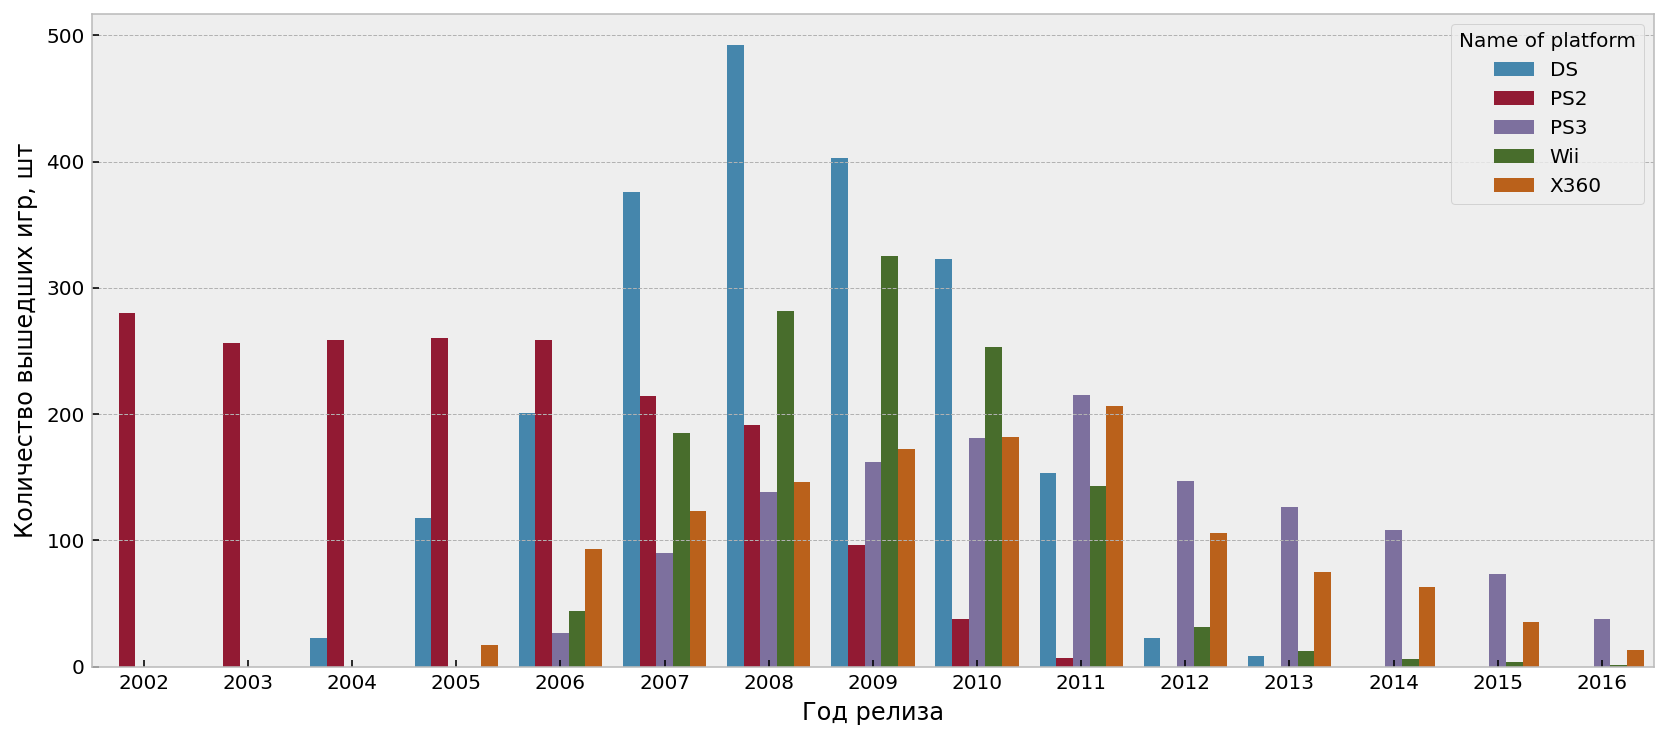

In [46]:
sns.barplot(data = since_2002.query('platform in ["PS2", "DS", "Wii", "PS3", "X360"]') \
            .groupby('platform', as_index=False)['year_of_release'] \
            .value_counts() \
            , x="year_of_release", y="count", hue="platform")
plt.legend(loc='upper right', title='Name of platform')
plt.xlabel('Год релиза')
plt.ylabel('Количество вышедших игр, шт')
plt.show()
# построим столбчатую диаграмму по количеству игр, вышедших для каждой платформы из топ 5, по годам

**Комментарий к столбчатой диаграмме:**

- поскольку у нас получился не совсем наглядный график, далее будет построен отдельный график для каждого года

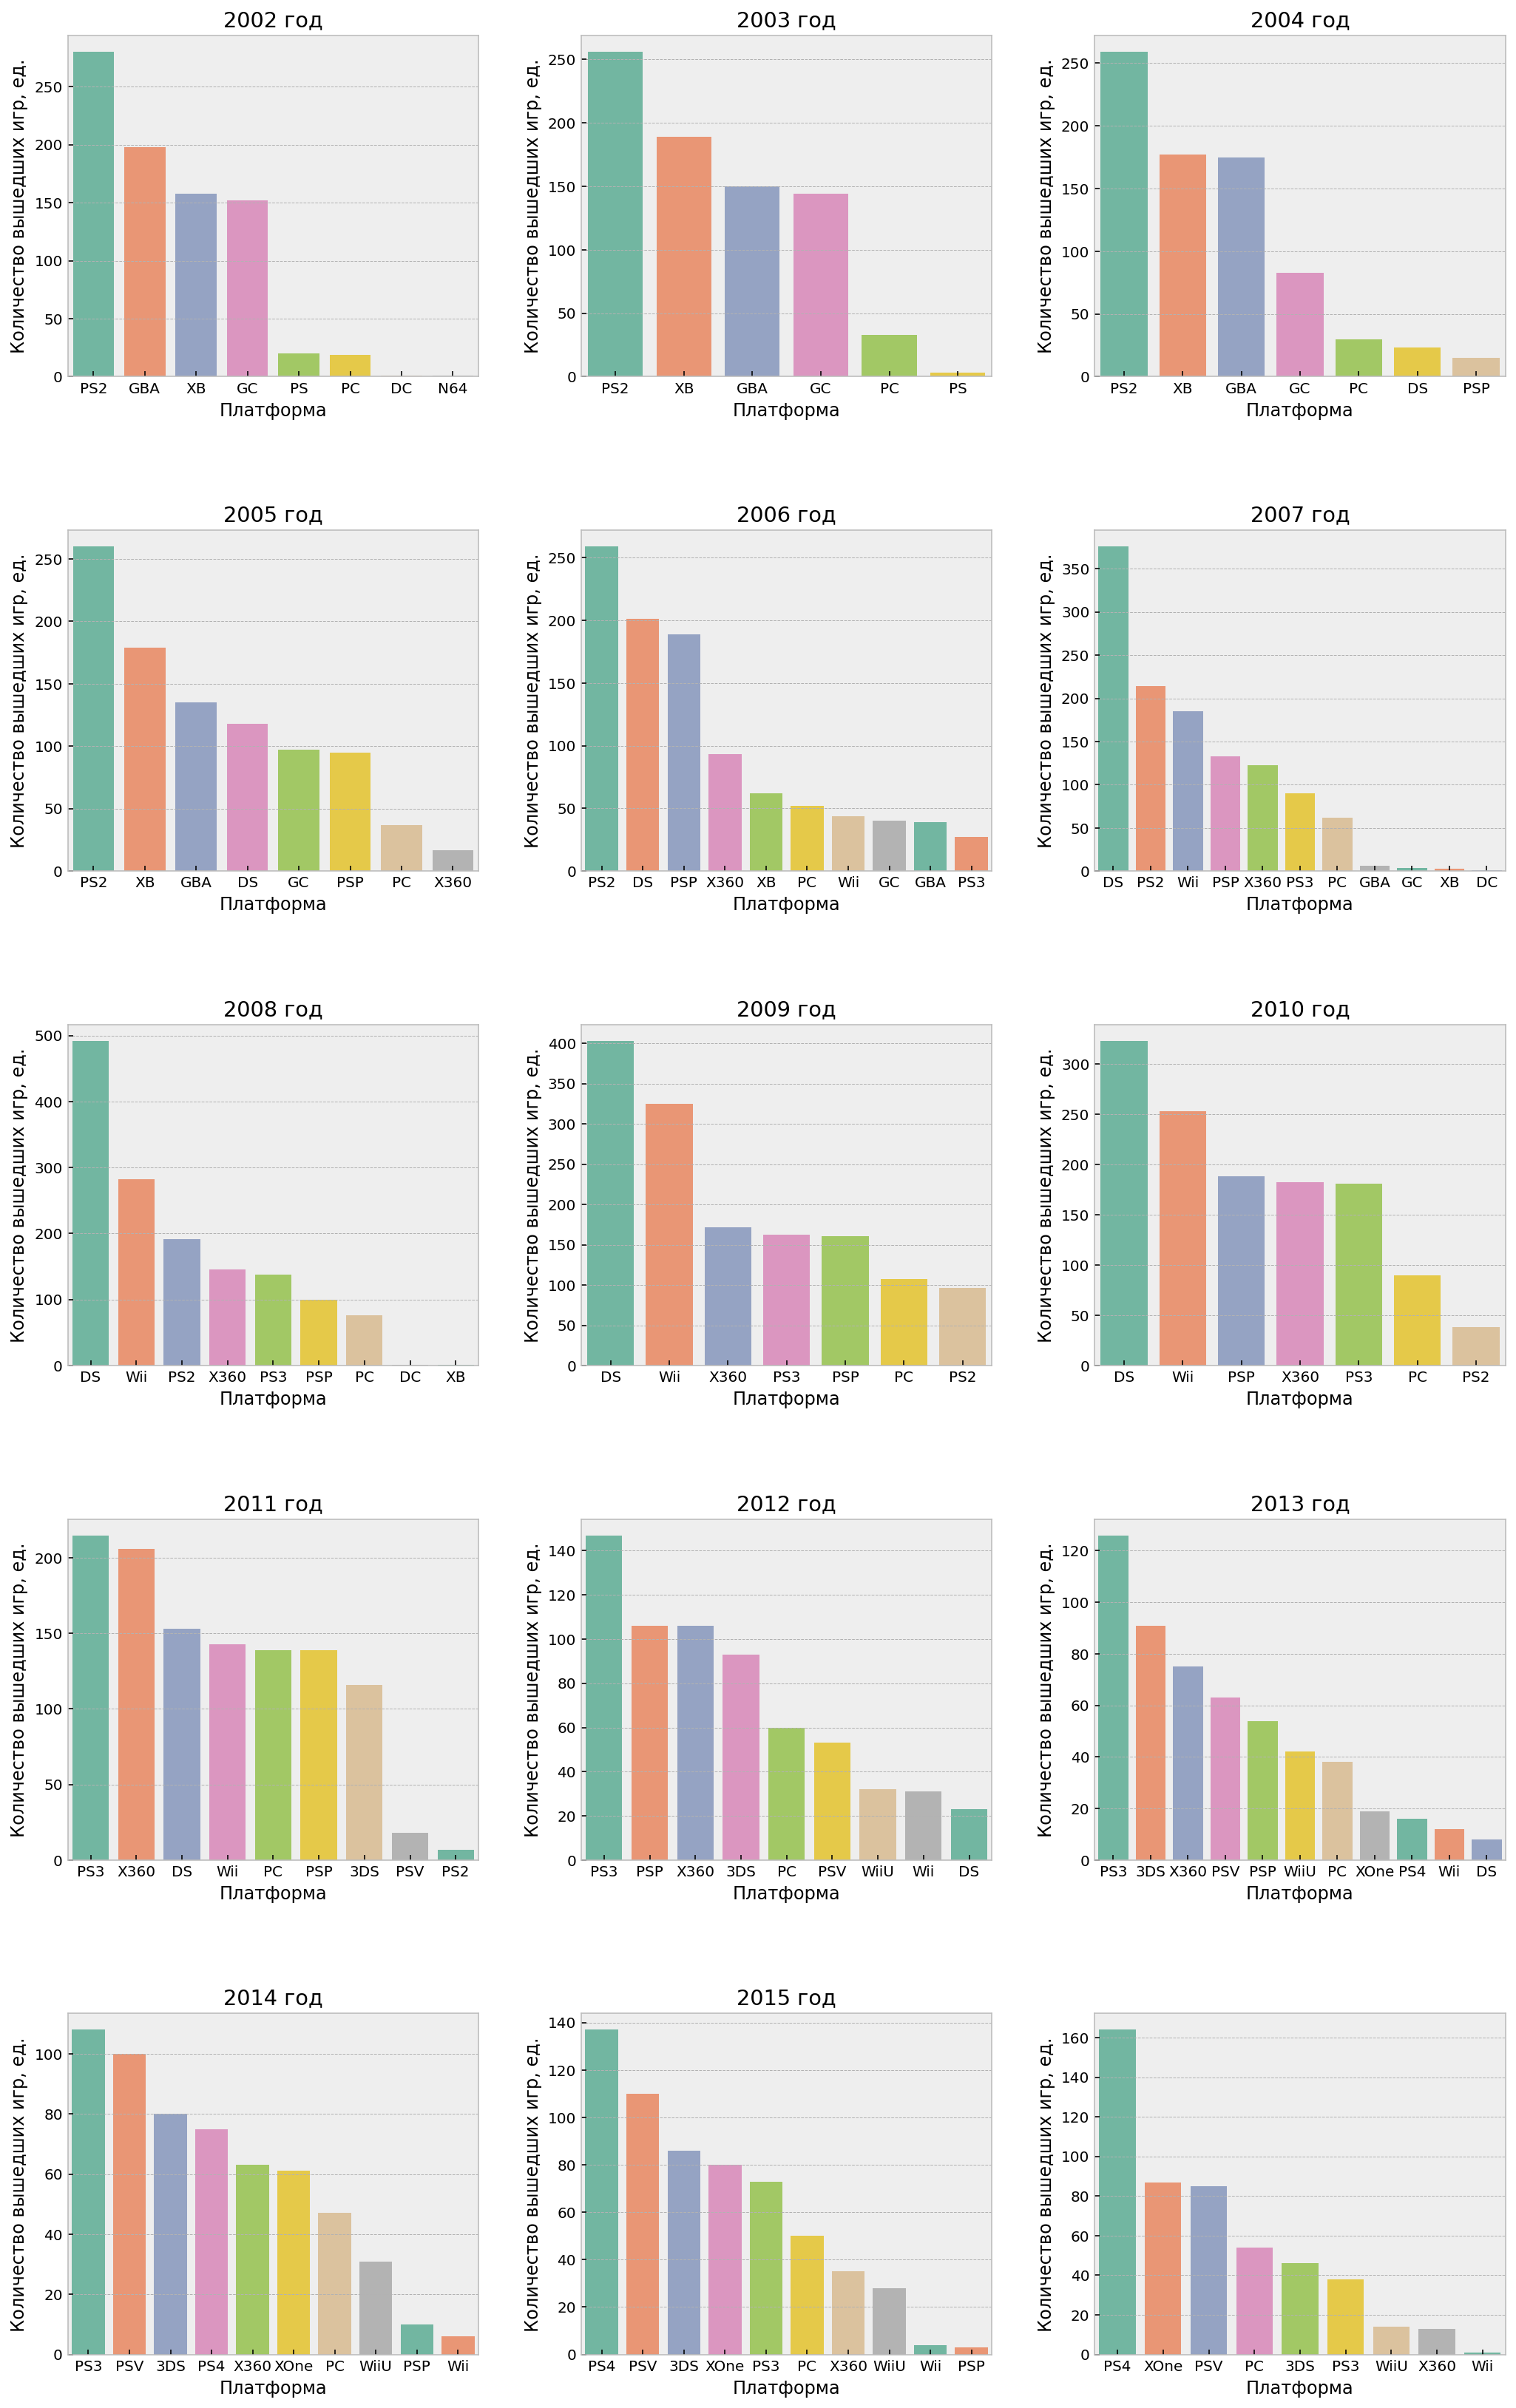

In [47]:
fig = plt.figure(figsize=(18, 35))
plt.subplots_adjust(left=0.15, wspace=0.25, hspace=0.45)

for i in enumerate(sorted(years)):
    plt.title(f'{i[1]-1} год')
    plt.subplot(6, 3, i[0]+1)
    sns.barplot(data = df[df['year_of_release'] == i[1]] \
            .groupby(['platform', 'year_of_release'], as_index=False)['rating'].count() \
            .rename(columns={'rating': 'amount'}) \
            .sort_values('amount', ascending=False) \
            , y='amount', x='platform', palette='Set2')
    plt.xlabel('Платформа')
    plt.ylabel('Количество вышедших игр, ед.')
# строим для каждого года столбчатую диаграмму количества выпускаемых игр по платформам

**Комментарий к полученному столбчатым диаграммам:**

- до 2008 года абсолютным лидером индустрии являлась консоль от Sony - PS 2 ,однако в 2007 году ее обогнал продукт от Nintendo - DS
- стоит отметить, что консоль от нинтендо вышла еще в 2004 году и уже через год практически вошла в 3 лидеров по объему выпущенных для нее игр
- доминация DS на рынка продолжалась до 2011 года, когда PS 3 - вышедшая в конце 2006 года - набрала необходимую популярность у новых игроков и ее старые игроки перешли на более новую модель
- PS 3 же в свою очередь была лидером до 2015 года, далее лидерство переняла консоль следующего поколения от Sony - вышедшая в конце 2013 года

**Далее будем строить графики изменения суммарных продаж на самых популярных платформах по годам**


In [48]:
since_2002.pivot_table(index='platform', values='total_sales', aggfunc='sum') \
    .sort_values(by='total_sales', ascending=False)
# определяем список наиболее популярных платформ

,total_sales
platform,
PS2,1028.000000
X360,960.000000
PS3,931.500000
Wii,891.000000
DS,802.500000
PS4,314.250000
PSP,289.500000
3DS,257.750000
GBA,251.250000


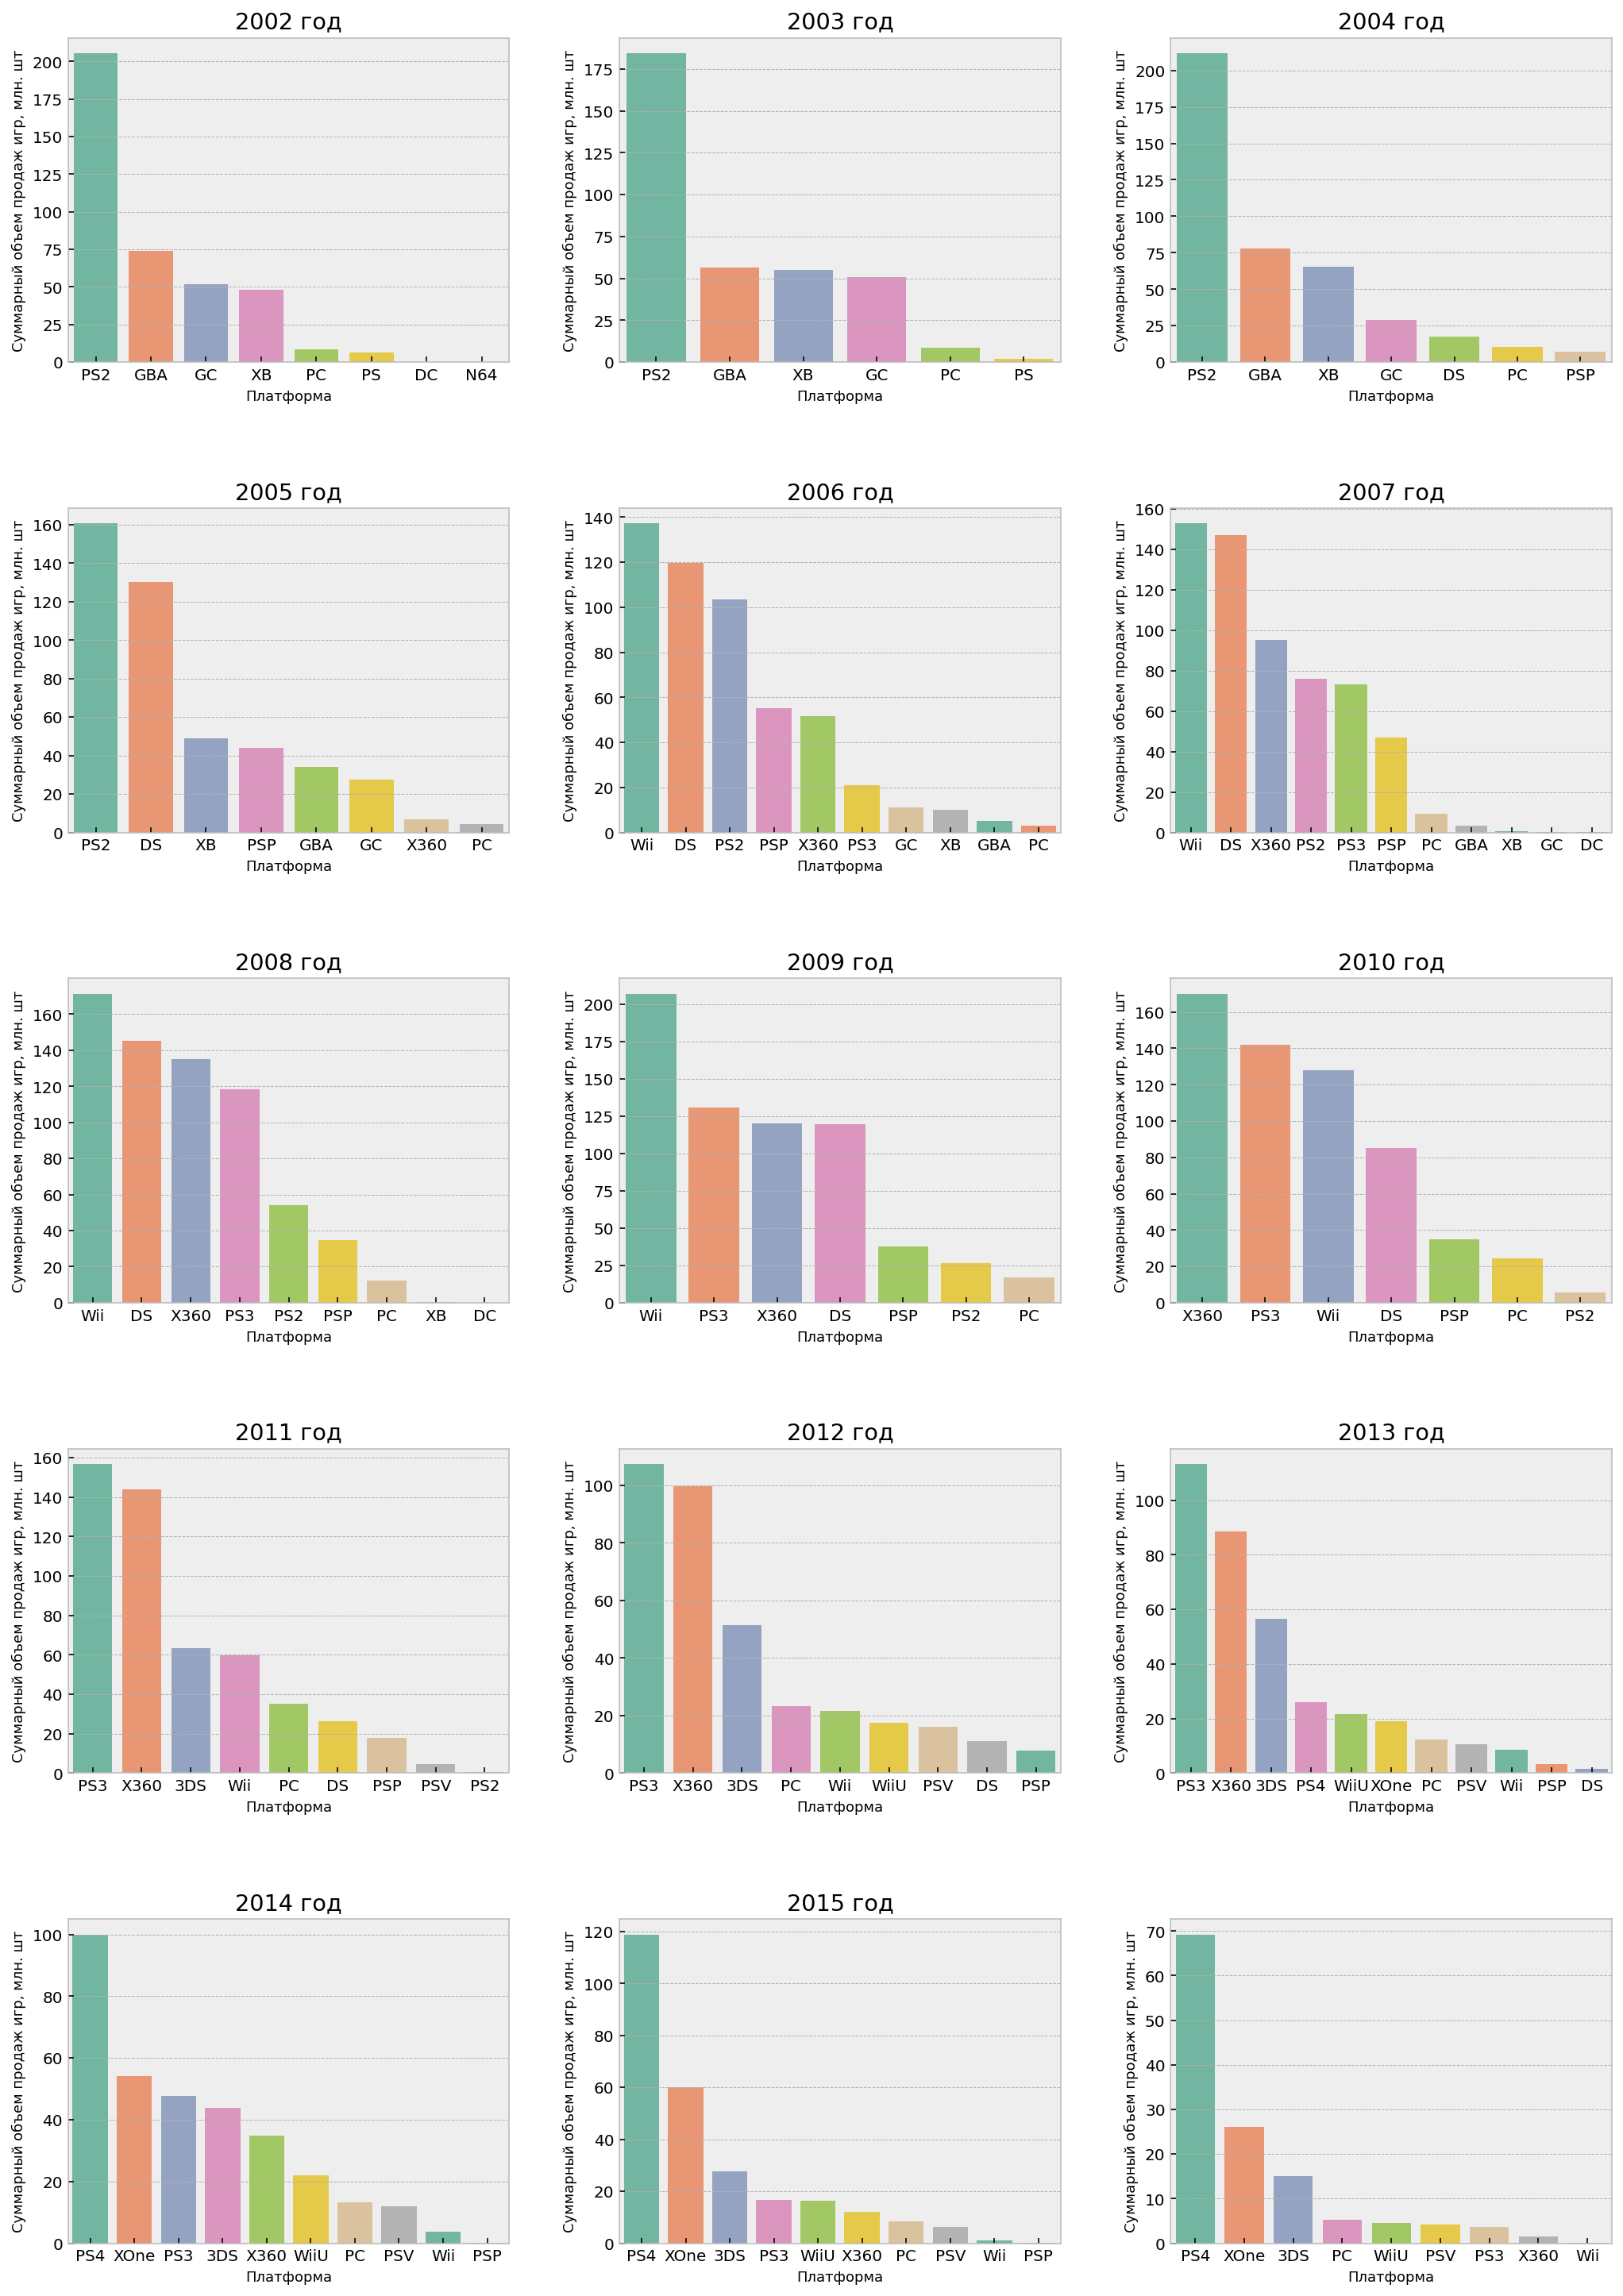

In [49]:
fig = plt.figure(figsize=(18, 31))
plt.subplots_adjust(left=0.15, wspace=0.25, hspace=0.45)

# fig.title('Динамика изменения количества вышедших игр по платформам за период 2012 - 2016 годов', fontsize=16)
    
for i in enumerate(sorted(years)):
        plt.title(f'{i[1]-1} год')
        plt.subplot(6, 3, i[0]+1)
        sns.barplot(data = df[df['year_of_release'] == i[1]] \
            .groupby(['platform', 'year_of_release'], as_index=False)['total_sales'].sum() \
            .sort_values('total_sales', ascending=False)
            , y='total_sales', x='platform', palette='Set2')
        plt.xlabel('Платформа', fontdict={'fontsize':9})
        plt.ylabel('Суммарный объем продаж игр, млн. шт', fontdict={'fontsize':9})
        
# построим столбчатые диаграммы суммарных продаж по платформам за 2002 - 2016 года

**Комментарий к полученным столбчатым диаграммам:**

- средний срок жизни консоли - 6-8 лет, это видно на примере PS 2, DS и Wii, все эти консоли имели пик популярности на протяжении 6-8 лет, далее производитель или конкурент выпускал более современную модель и игроки переключались на другие платформы
- PS 2 была в тройке лидеров по общим продажам до 2007 года, поскольку уже в 2007 году часть игроков перешла на PS 3, вышедшую в конце 2006 года, что повлияло на общие продажи игр для PS 2 
- PS 3 же входила в тройку лидеров на протяжении 6 лет
- учитывая, что PS 2 вышла в 2000 году, можно предположить, что срок ее лидерства был примерно таким же, что и у PS 3
- практически аналогичная ситуация и с остальными популярными платформами - Wii, XB, PSP,DS и GBA

**Далее рассмотрим более релевантный отрезок времени и изучим как менялись продажи в последние годы**

In [50]:
relevant_df = df.query('year_of_release > 2013')
# создаем дата фрейм с актуальной для проведения исследования информацией

In [51]:
relevant_paltforms = relevant_df.groupby('platform', as_index=False)['total_sales'].sum() \
           .sort_values('total_sales', ascending=False)
relevant_paltforms
# посмотрим суммарные продажи по платформам за интересующий период времени

,platform,total_sales
3,PS4,288.250000
9,XOne,140.375000
0,3DS,86.687500
2,PS3,68.187500
8,X360,48.218750
7,WiiU,42.968750
1,PC,27.046875
5,PSV,22.406250
6,Wii,5.070312
4,PSP,0.360107


In [52]:
top_5_platforms = relevant_paltforms['platform'].head().to_list()
# выбираем наиболее перспективные платформы

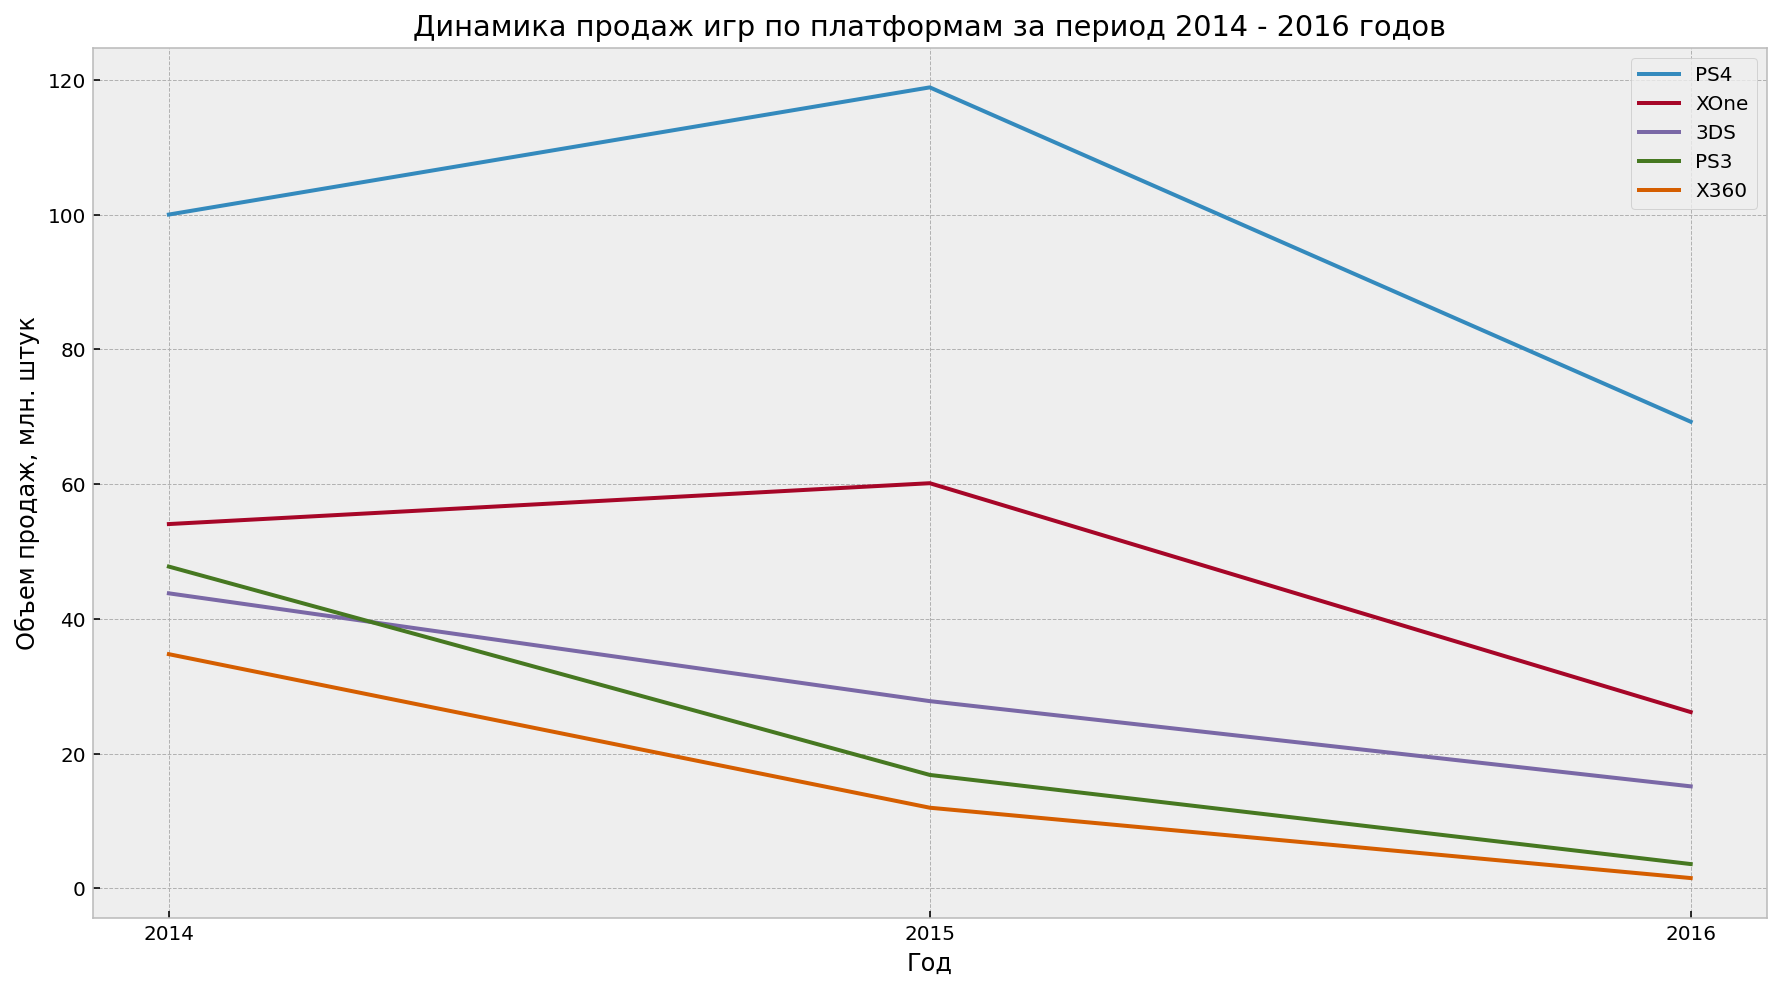

In [53]:
for platform in top_5_platforms:
    relevant_df.query('platform == @platform') \
               .groupby('year_of_release')['total_sales'].sum() \
               .plot(figsize=(15, 8), label = platform)
plt.xticks(np.arange(2014, 2017, step=1))
plt.title('Динамика продаж игр по платформам за период 2014 - 2016 годов')
plt.xlabel('Год')
plt.ylabel('Объем продаж, млн. штук')
plt.legend()
plt.grid(True)
# строим график объема суммарных продаж для наиболее перспективных платформ по интересующему нас периоду

**Комментарий к полученным столбчатым диаграммам:**

- после 2015 года объем на всех платформах произошел спад продаж, однако, скорее всего, это можно объяснить тем, что в дата фрейме данные не за весь 2016 год
- говоря о перспективных платформах, стоит упомянуть бесспорного лидера индурстрии - PS 4, а также XOne и 3DS

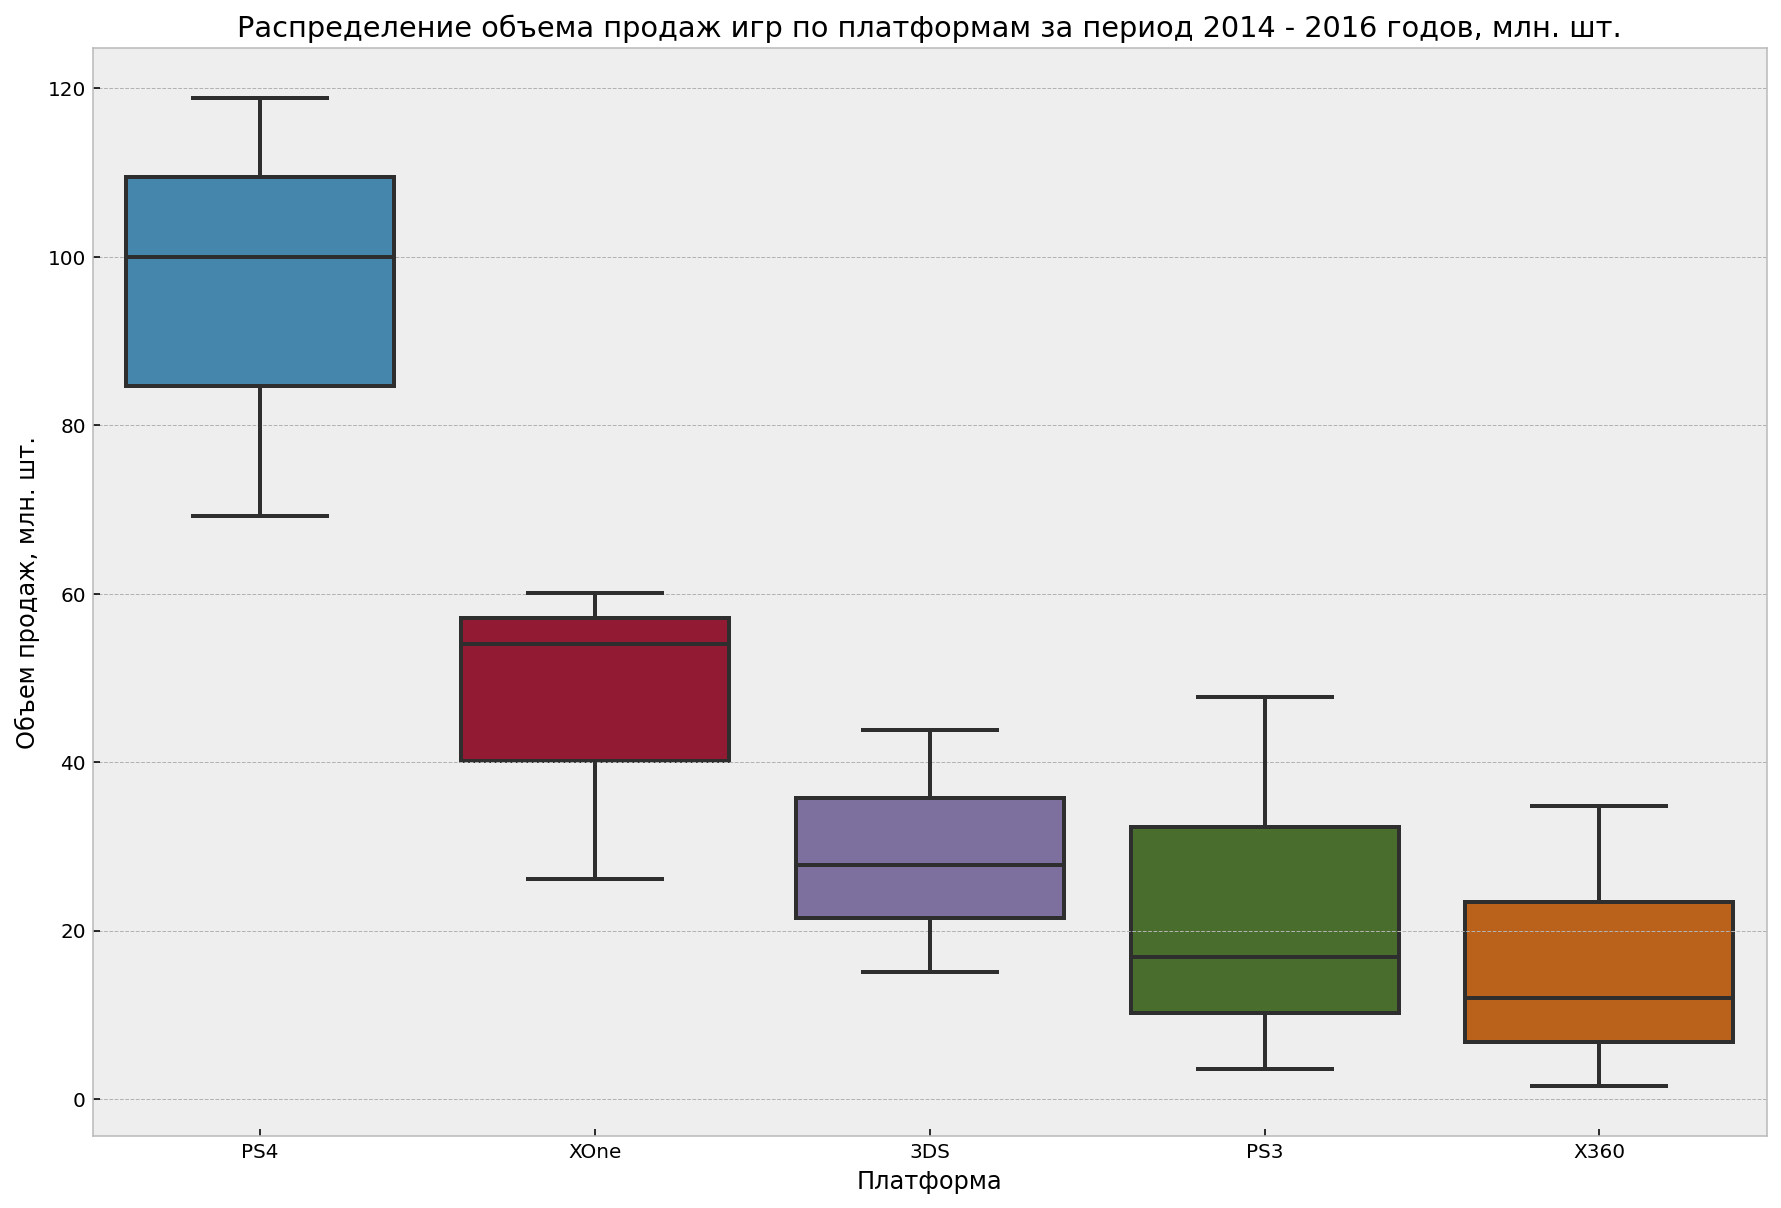

In [54]:
plt.figure(figsize=(15,10))

sns.boxplot(data = relevant_df.query('platform == ["PS4", "XOne", "3DS", "PS3", "X360"]') \
                    .groupby(['year_of_release', 'platform'])['total_sales'].sum() \
                    .reset_index(), 
            x='platform', y='total_sales', order=top_5_platforms, orient='v'
           )
plt.title('Распределение объема продаж игр по платформам за период 2014 - 2016 годов, млн. шт.')
plt.xlabel('Платформа')
plt.ylabel('Объем продаж, млн. шт.')
plt.show()
# построим боксплоты по объему продаж игр на разных платформах за период 2014 - 2016 годов

**Комментарий к полученному графику с boxplot'ами:**

- наибольший межквартильный размах у PS 4 - порядка 25 млн. шт, что является следвствием наибольшего абсолютного снижения (порядка 50 млн. штк) на графике "Динамика продаж игр по платформам за период 2014 - 2016 годов"(см. выше)
- наименьшая волатильность в продажах у 3DS и X360, это говорит о том, что аудитория этих платформ может и покупает меньше игр, чем игроки флагманских продуктов на рынке конселей таких, как PS 4 или XOne, но зато большининство игроков, покупающих игры на них, последовательны в своем потребительском поведении, что позволяет проще прогнозировать выручку и объемы продаж
- по боксплоту PS 3 можно понять, что с каждым годом, все больше и больше игроков переходит на последний продукт компании - PS 4, поэтому его график настолько длинный (разница между максимумом и минимумом)
- у XOne и X360 ситуауия аналогична вышеописанной, однако в силу того, что абсолютные продажи у данных платформ меньше, чем у продуктов компании Sony, которые выходили +/- в одно и то же время (PS 3 и X360; PS 4 и XOne)

**Далее изучим как влияют отзывы об игре на объем ее продаж в разрезе разных платформ, для это построим диаграмму рассеивания и посчитаем матрицу корреляции**

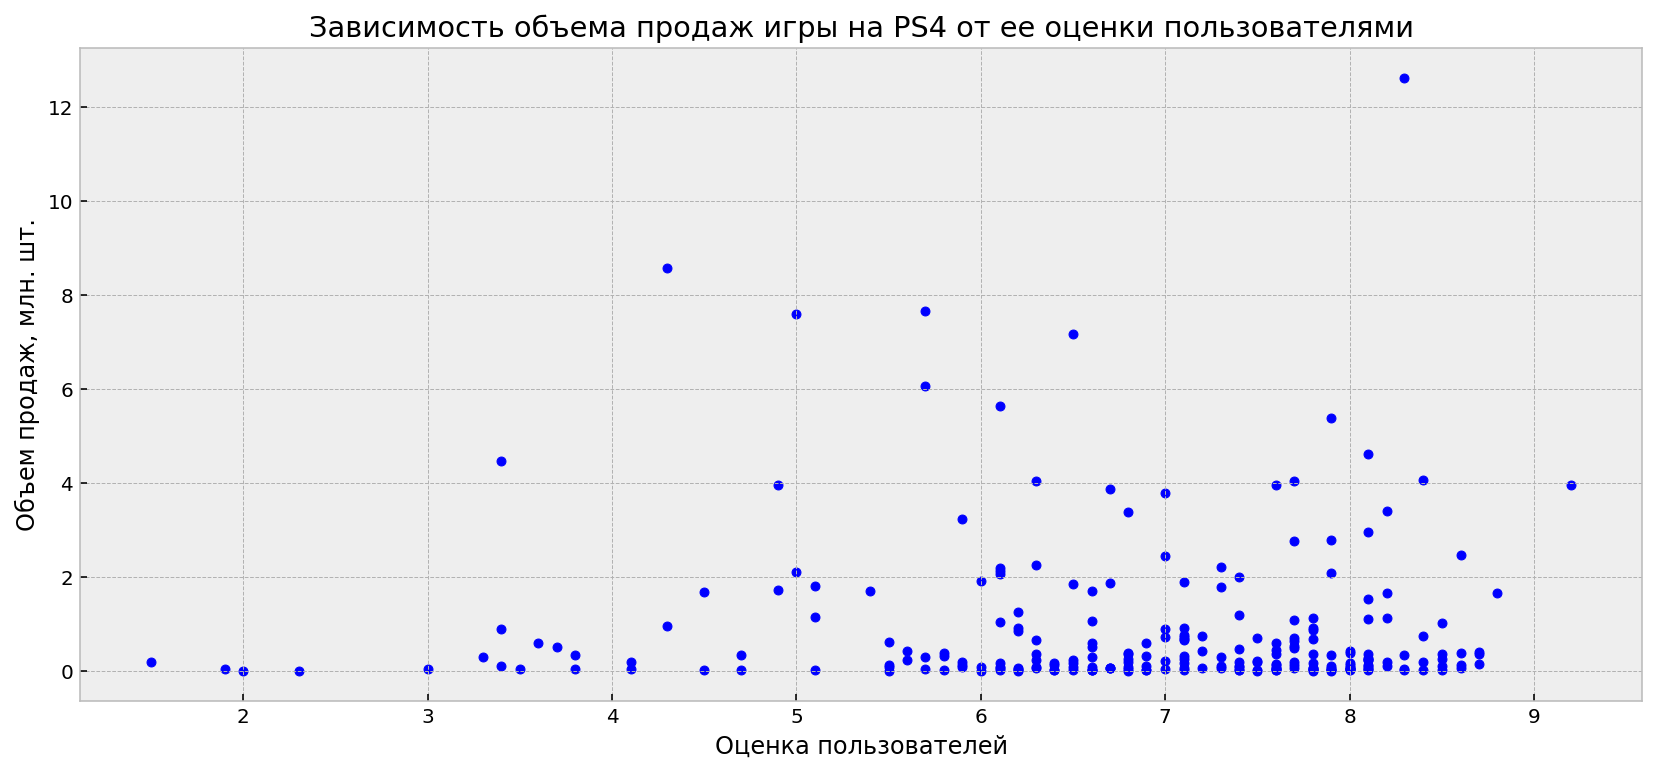

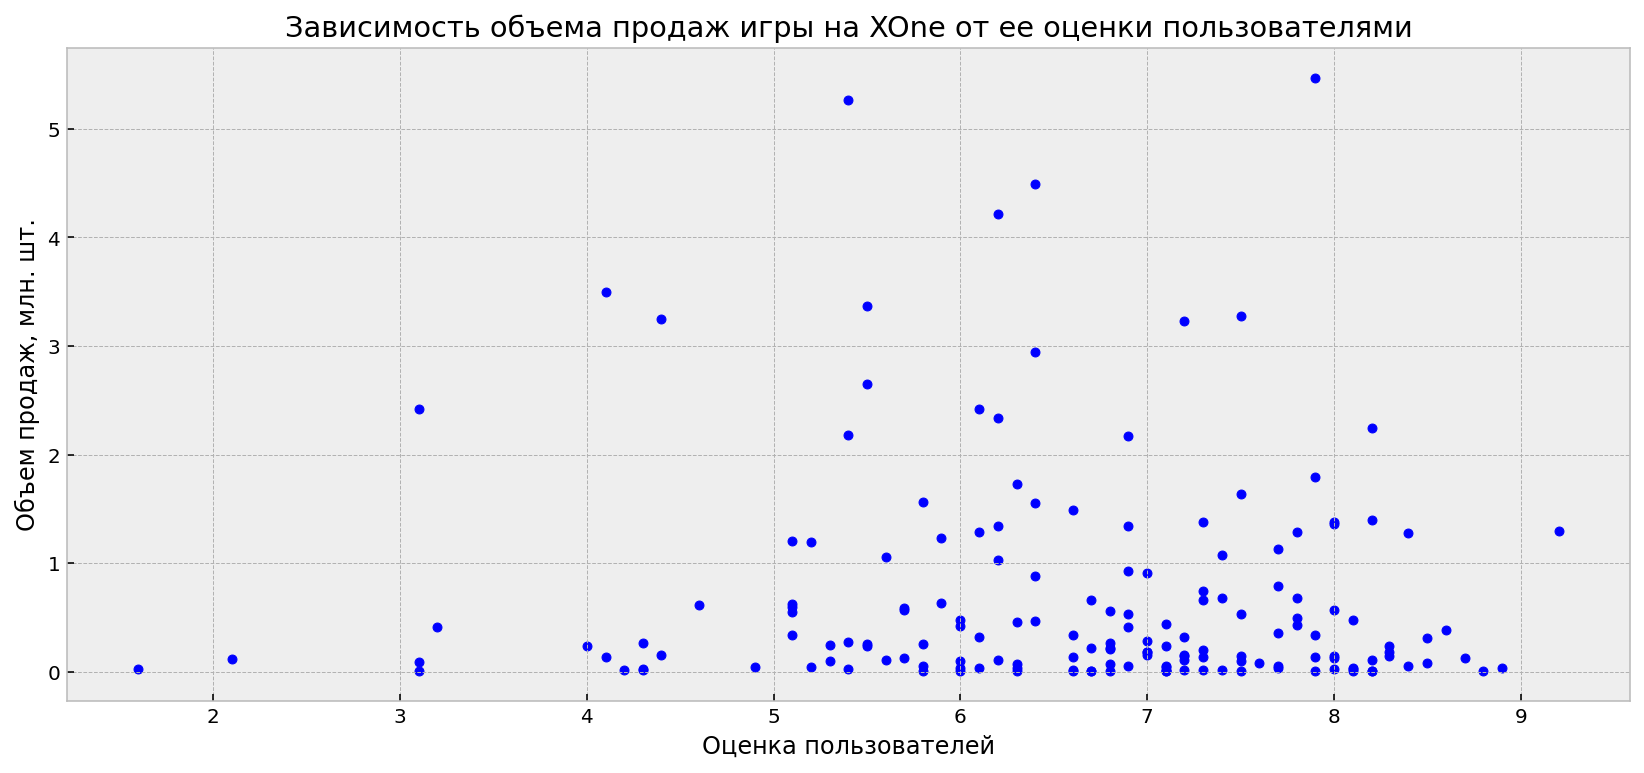

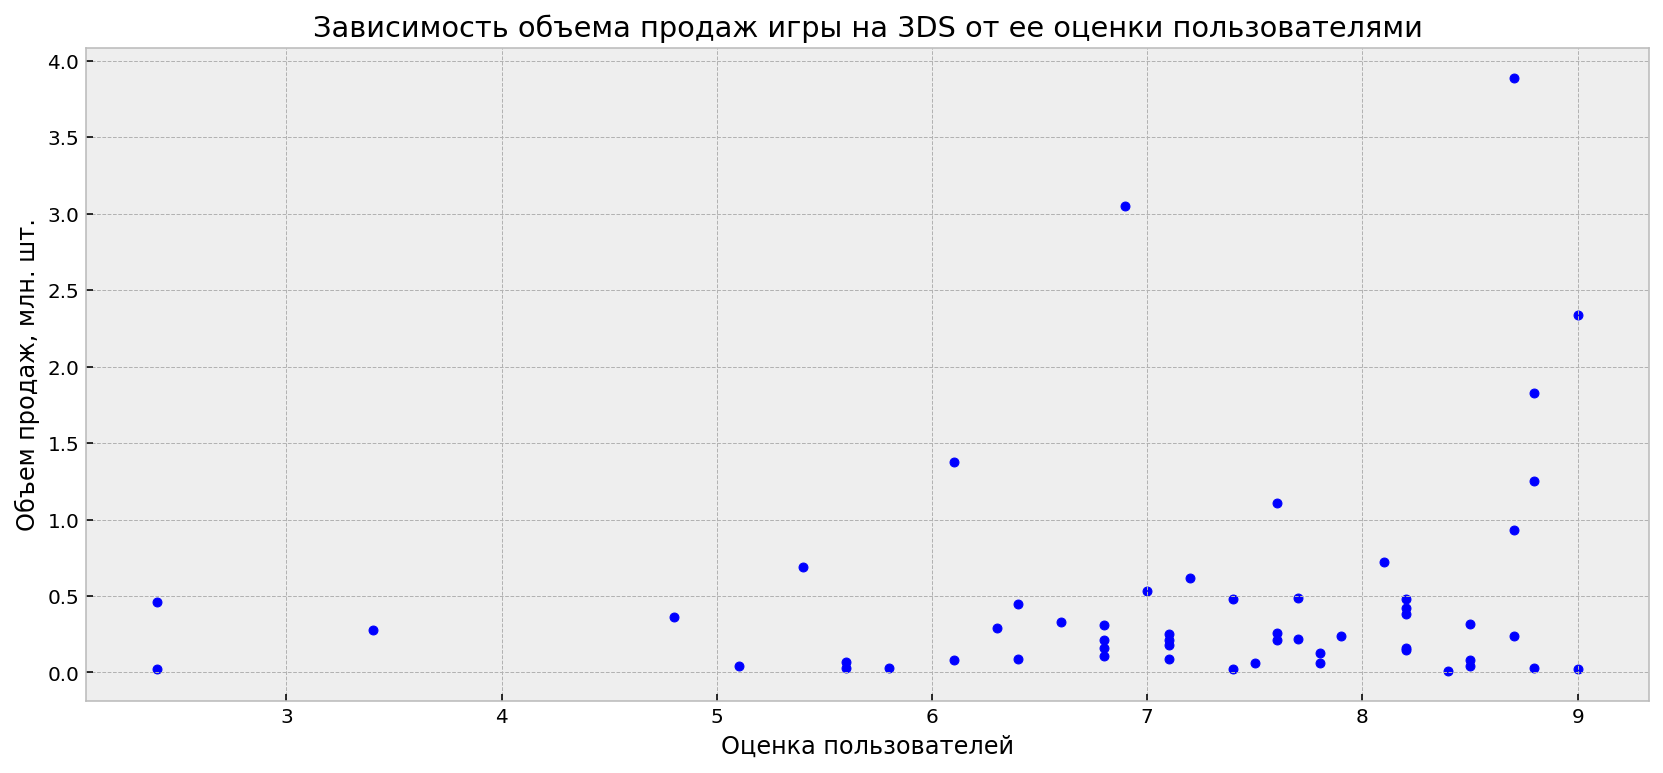

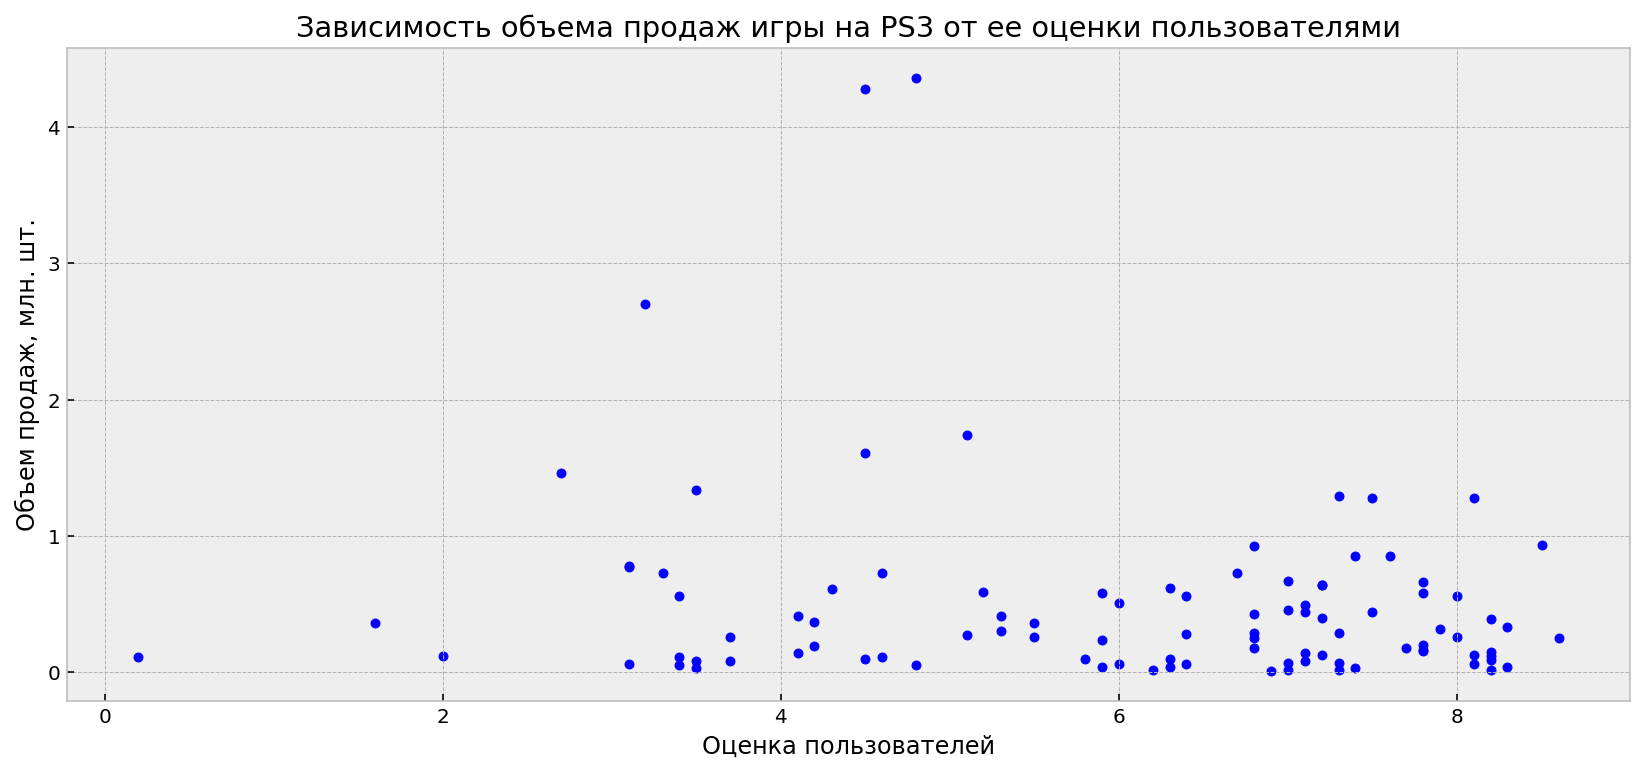

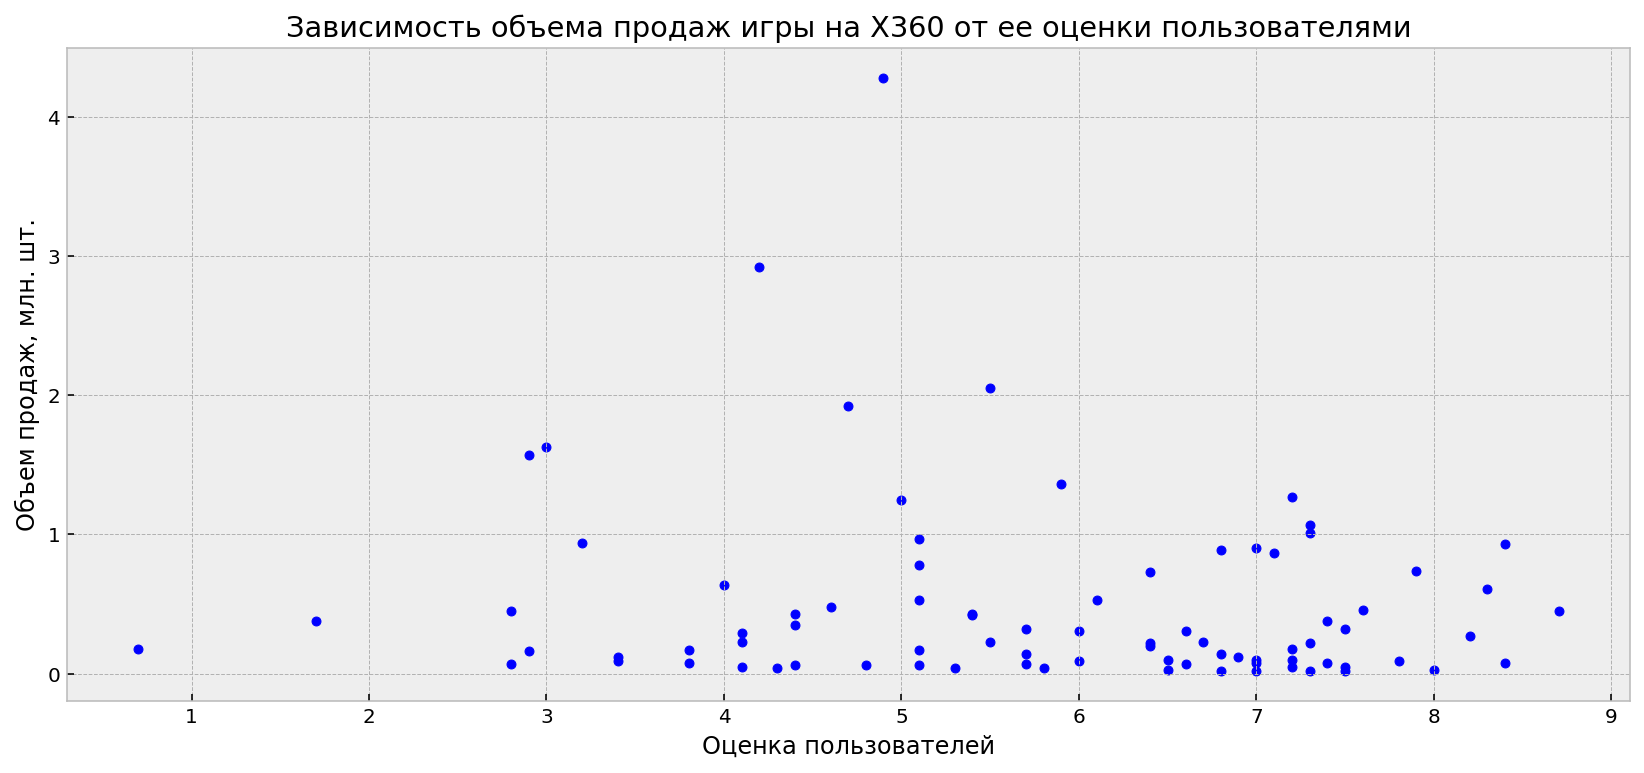

In [55]:
for plat in enumerate(top_5_platforms):
    relevant_df[relevant_df['platform'] == plat[1]].plot(x='user_score', y='total_sales', kind='scatter', grid=True)
    plt.title(f'Зависимость объема продаж игры на {plat[1]} от ее оценки пользователями')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Объем продаж, млн. шт.')
    plt.show()
# построим диаграммы рассеивания зависимоти объема продаж игры на разных платформах от оценки пользователей
# за период 2014 - 2016 годов

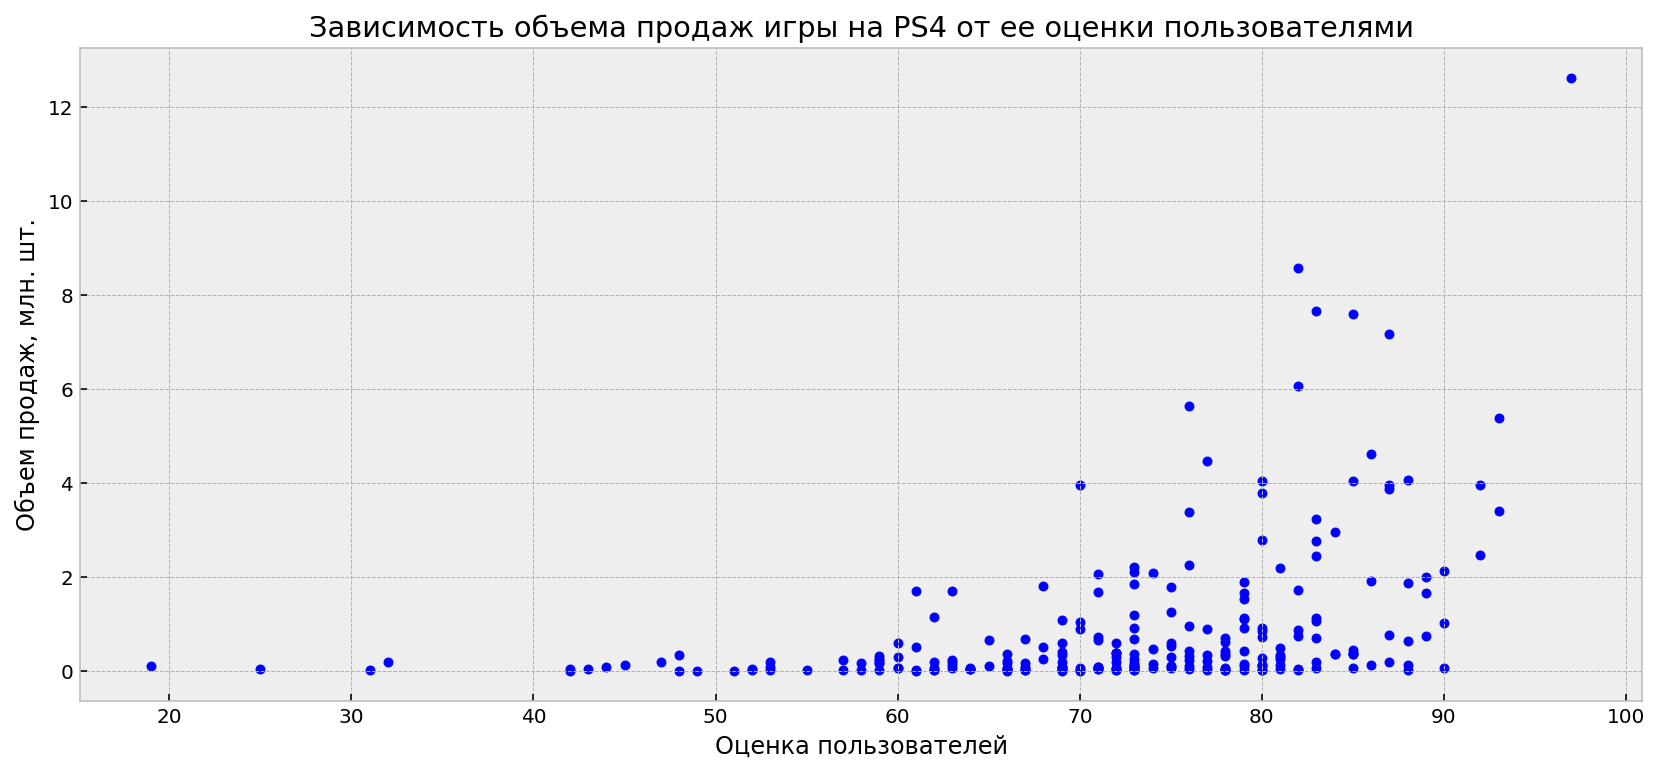

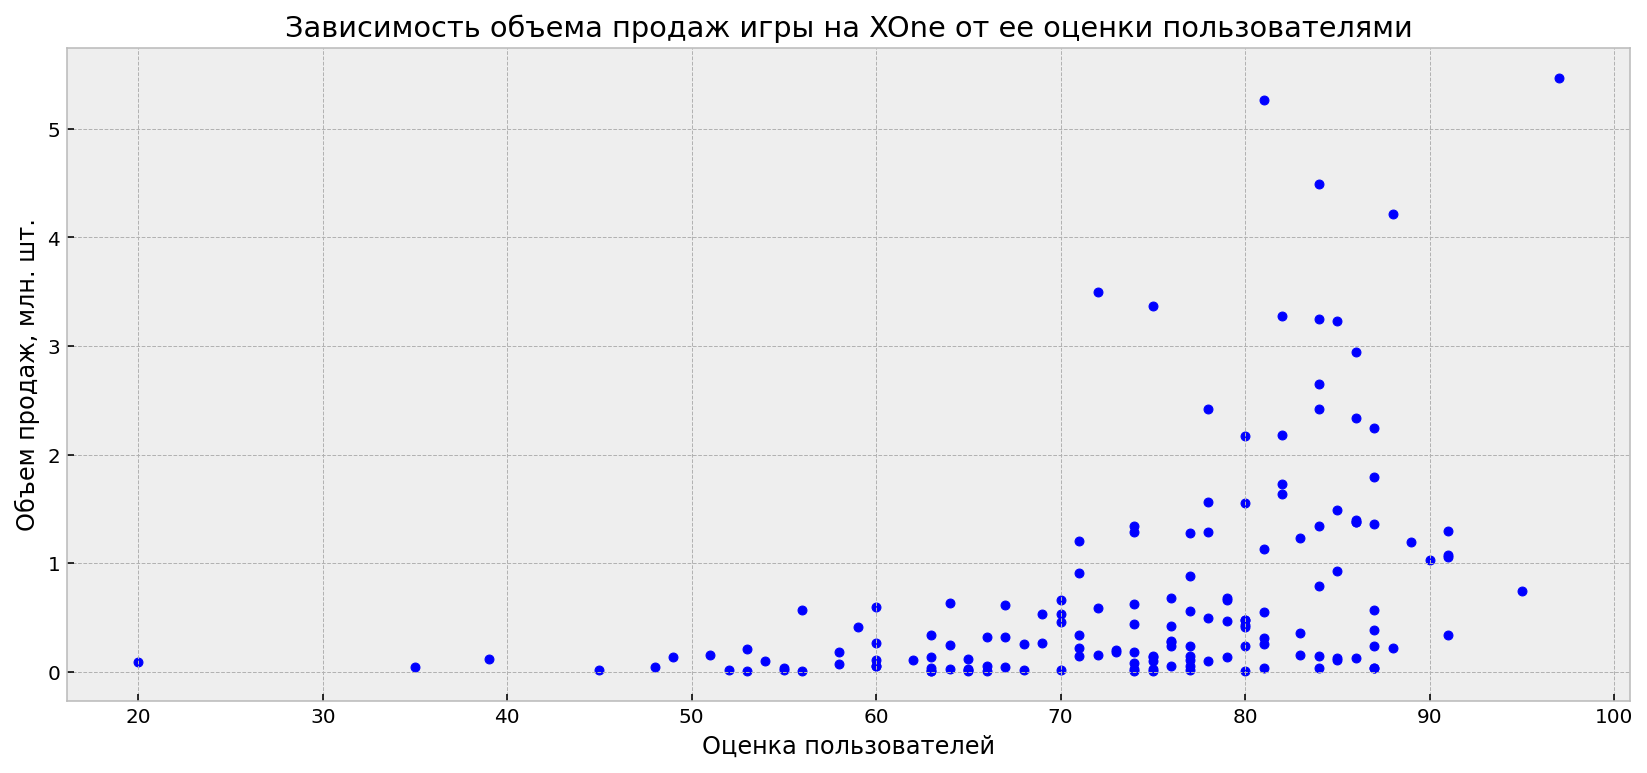

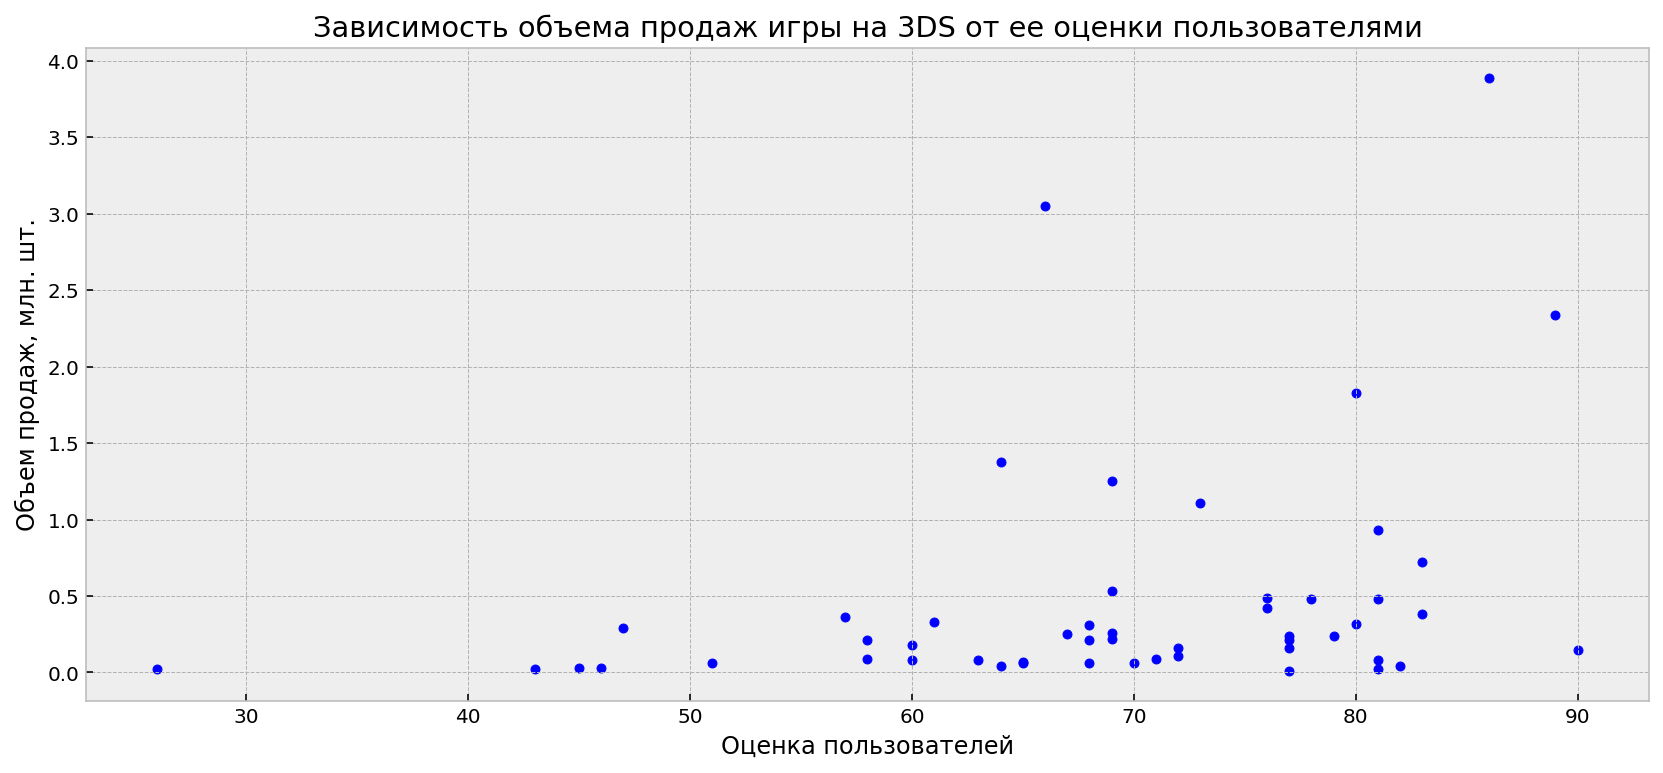

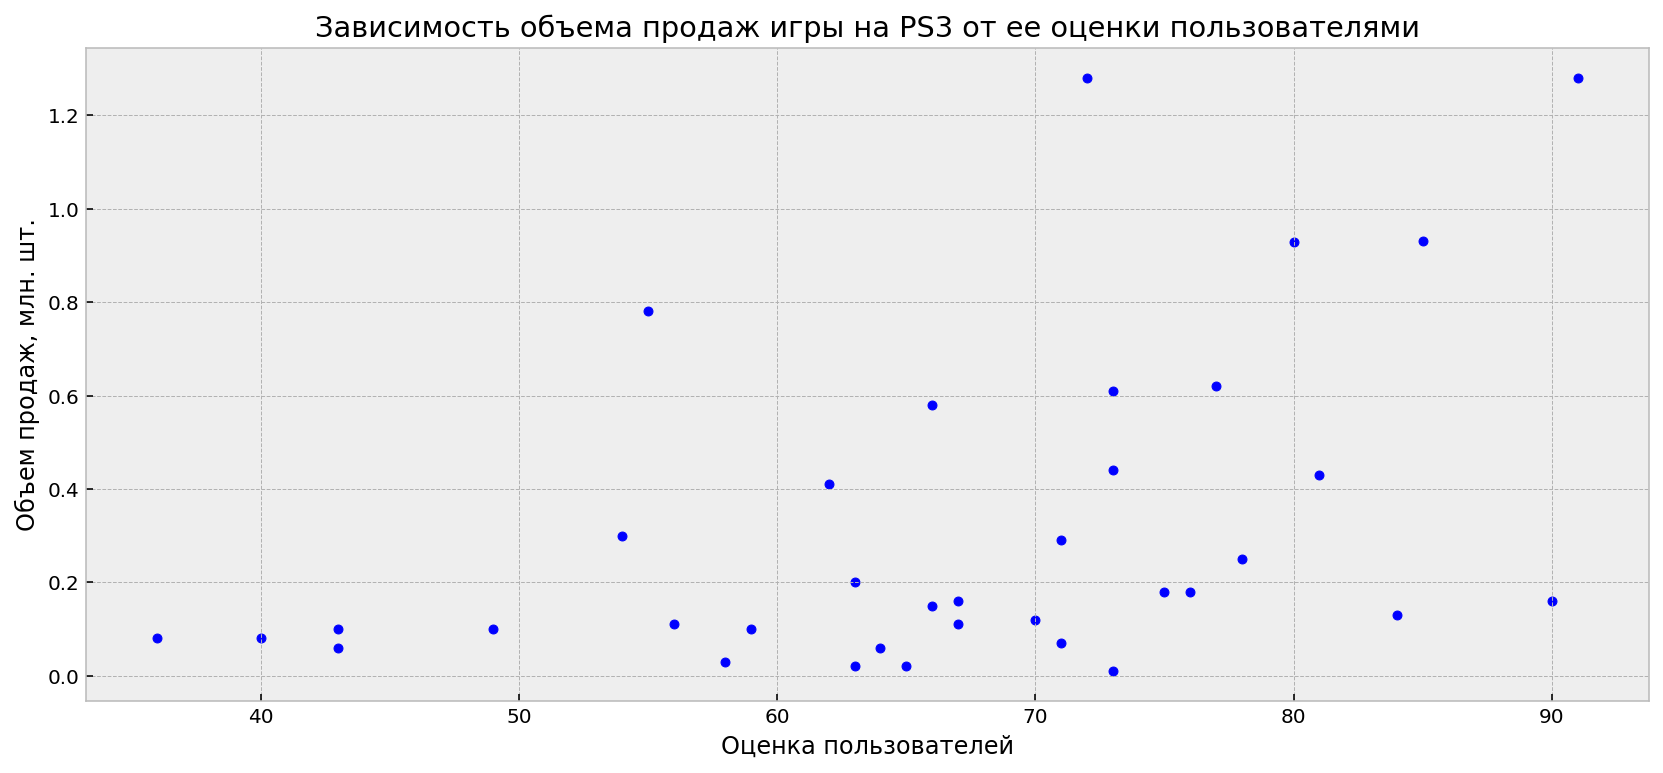

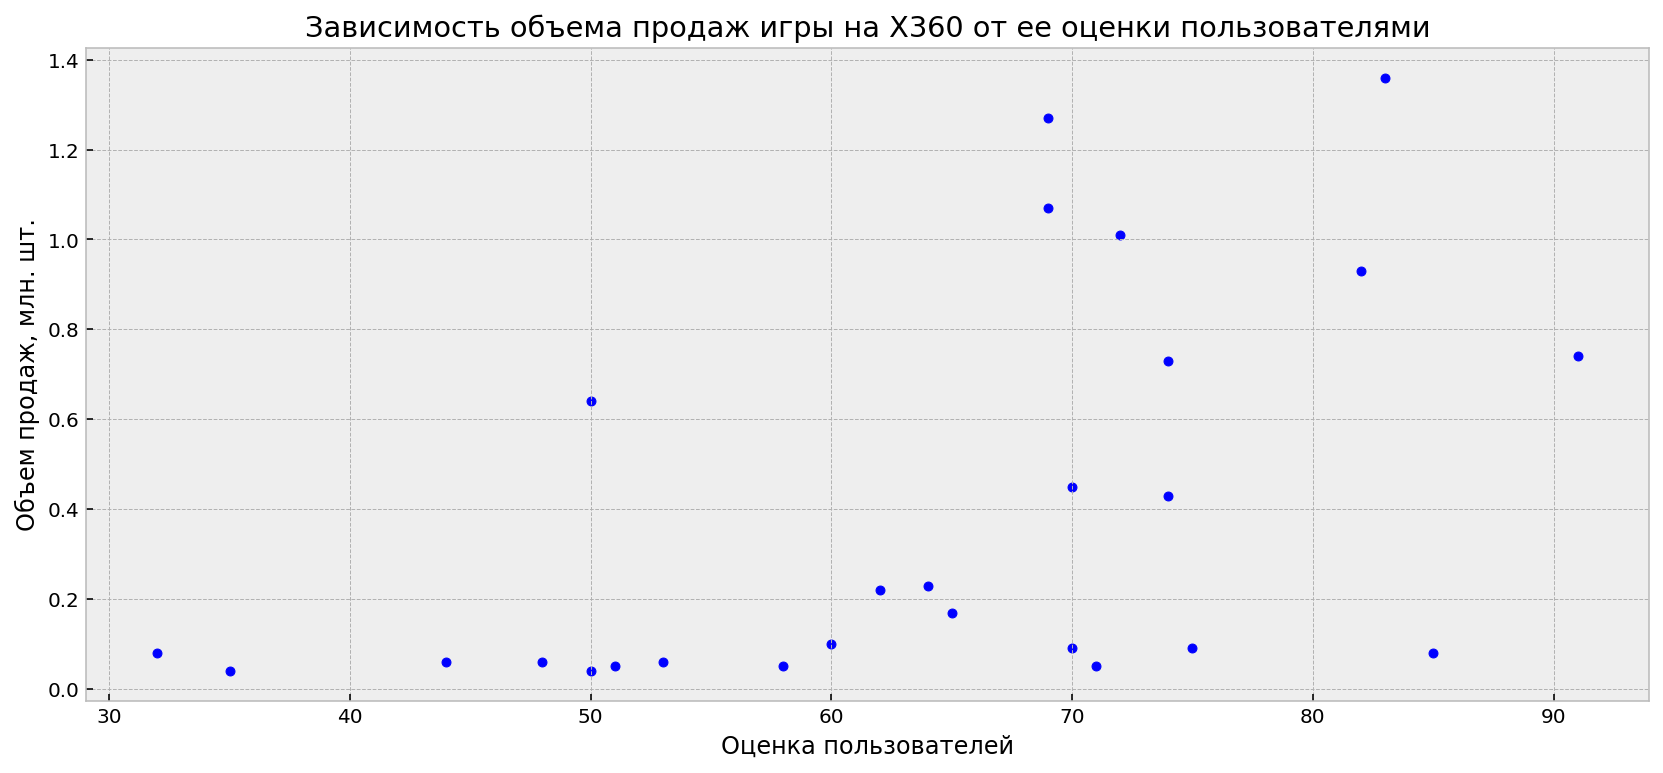

In [56]:
for plat in enumerate(top_5_platforms):
    relevant_df[relevant_df['platform'] == plat[1]].plot(x='critic_score', y='total_sales', kind='scatter', grid=True)
    plt.title(f'Зависимость объема продаж игры на {plat[1]} от ее оценки пользователями')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Объем продаж, млн. шт.')
    plt.show()
# построим диаграммы рассеивания зависимоти объема продаж игры на разных платформах от оценки критиков
# за период 2014 - 2016 годов

**Комментарий к полученным графикам рассеивания:**

- можно с уверенностью сказать, что оценки критиков более объективные, чем мнение игроков, поскольку у игр с низкой пользовательской оценкой намного чаще бывают высокие продажи, нежели если критик поставил низкую оценку, что в принципе, ожидаемо, так как критики ставят оценки в соотвествии со своим опытом, который зачастую богаче, чем у игроков, а также низкая оценка пользователя не всегда является следствием плохой разработки или неинтересного сюжета, возможно, конкретному игроку просто что-то не понравилось или игра залагала в важный момент и прогресс не сохранился - вообщем, причин низкой оценки от юзеров может быть масса, но любая оценка пользователя дает повод задуматься разработчикам об улучшениях своего продукта, даже если она необъективная
- так же стоит заметить, что на платформах X360 и PS 3 оценки критиков были менее точные, то есть было довольно-таки много случаев, в которых игра с низкой оценкой от эксперта продавалась большим тиражом, в сравнении с более современными платформами - XOne и PS 4
- объяснить ситуацию из пункта выше могут следующие гипотезы: 
1. с развитием гейм индустрии появилось большее количество критиков, поэтому оценка стала более объективной
2. критики, оценивающие игры во времена  X360 и PS 3 не имели четких критериев / не было методологии оценки (или со временем ее принципиально пересмотрели, что сделало ее более объективной)
3. со времен X360 и PS 3 у критиков прокачалась насмотренность, поэтому оценки стали более точными
4. люди стали больше слушать критиков, и теперь игры с низкими оценками от критиков практически обречены на низкие продажи (рост важности мнения экспертов / инфлюэнсеров)
- в общем, причин опять же может быть много, но сам факт того, что популярность игры среди игроков зависит больше от оценки критиков, нежели, чем от оценки пользователей - 100%

**Далее посчитаем матрицу корреляции между вышеуказанными факторами**

In [57]:
for plat in enumerate(top_5_platforms):
    df_t = relevant_df[relevant_df['platform'] == plat[1]]
    print(f'Корреляция между оценкой пользователей и объемом продаж игры на {plat[1]}: \033[1m{round(df_t["total_sales"].corr(df_t["user_score"]), 2)}\033[0m')
    print(f'Корреляция между оценкой критиков и объемом продаж игры на {plat[1]}: \033[1m{round(df_t["total_sales"].corr(df_t["critic_score"]), 2)}\033[0m')
    print()
# считаем корреляцию между оценкой игроков / критиков и объемом продаж игры

Корреляция между оценкой пользователей и объемом продаж игры на PS4: -0.04
Корреляция между оценкой критиков и объемом продаж игры на PS4: 0.4

Корреляция между оценкой пользователей и объемом продаж игры на XOne: -0.07
Корреляция между оценкой критиков и объемом продаж игры на XOne: 0.43

Корреляция между оценкой пользователей и объемом продаж игры на 3DS: 0.22
Корреляция между оценкой критиков и объемом продаж игры на 3DS: 0.31

Корреляция между оценкой пользователей и объемом продаж игры на PS3: -0.17
Корреляция между оценкой критиков и объемом продаж игры на PS3: 0.45

Корреляция между оценкой пользователей и объемом продаж игры на X360: -0.14
Корреляция между оценкой критиков и объемом продаж игры на X360: 0.53



**Комментарий к полученным данным корреляции:**

- мой комментарий к диаграмма рассеивания **подтвердился** данными о корреляции  оценки от игроков / критиков и объемом продаж игры
- практически на всех платформах корреляция между оценкой пользователей и объемом продаж игры - **отрицательная**, то есть обратная, что означает, если у игры низкая пользовательской оценка - это далеко не факт того, что игра обречена на скудные объемы продаж, а, скорее, наоборот, однако с увереностью так сказать нельзя потому что
- практически все корреляционные связи между оценкой пользователей и объемом продаж игры - **очень слабые** - исключением является единственная положительная (прямая) зависимость на платформе **3DS**, которая так же единственная не очень слабая, а просто **слабая**
- говоря о связи между оценками экспертов и объемом продаж игры, стоит отметить что все они - **положительные**, как и говорилось выше, они более объективные по сравнению с мнением пользователей
- более того, оценки критиков имеют более сильную связь с объемом продаж, почти все они **умеренно связаны** с интересующим нас фактором, исключением является мнение критиков по поводу игр для X360, там связь аж **средней силы**, что опять же подтверждает их большую достоверность по сравнению с мнение пользователей
- сравнивая значения между платформами, помимо вышеупомянутых выбивающихся значений можно выделить следующие моменты:
1. на PS 4 и XOne связь между оценками пользователей и объемом продаж игры практически отсутствует - "-0.04" "-0.07" соответственно
2. умеренные положительные связи между оценками критиков и объемом продаж игры для платформ: PS4, XOne и PS3 больше "0.4", однако для консоли 3DS она лишь "0.31"
- в целом, дисперсия между оценками критиков и пользователей по платформам не особо большая, за исключением одной выбивающейся платформы - 3DS, у нее у единственной оценки игроков положительно связаны с объемом продаж, так еще эта связь сильнее среди всех связей между оценками пользователей и объемом продаж


**Комментарий к полученной столбчатой диаграмме:**

- два наиболее прибыльных жанра - "Action" и "Shooter" - приносят больше половины продаж, а более 100 млн. проданных копий за 2014 - 2016 года имеют лишь 4 жанра, помимо вышеупомянутых жанров это "Sports" и "Role-Playing"
- продажы самого популярного жанра ("Action") превысили продажи наименее популярного ("Puzzle") более чем в 90 раз
- можно предположить, что подобная ситуация сложилась из-за характерной особенности консолей, как платформы для игры, поскольку большинство людей подключает их либо к телевизору, либо к большому монитору, то в игры таких жанров, как "Strategy" и "Puzzle" и других жанров, имеющих низкие продажи, просто напросто неудобно играть на таких устройствах, а также любителям подобных игр необязательно иметь консоль, поскольку на мобильных устройствах игры данных жанров имеют наибольшую популярность среди игроков, что и является основной причиной, почему вышеуказанные жанры имеют слабые продажы на консолях

In [81]:
relevant_df.groupby('genre', as_index=False) \
                      .agg({'total_sales': 'sum'}) \
                      .sort_values('total_sales', ascending=False) \
                      .reset_index()

,index,genre,total_sales
0,0,Action,199.375000
1,8,Shooter,171.000000
2,10,Sports,109.500000
3,7,Role-Playing,101.437500
4,3,Misc,37.562500
5,2,Fighting,28.218750
6,6,Racing,27.531250
7,4,Platform,18.093750
8,1,Adventure,17.546875
9,9,Simulation,13.132812


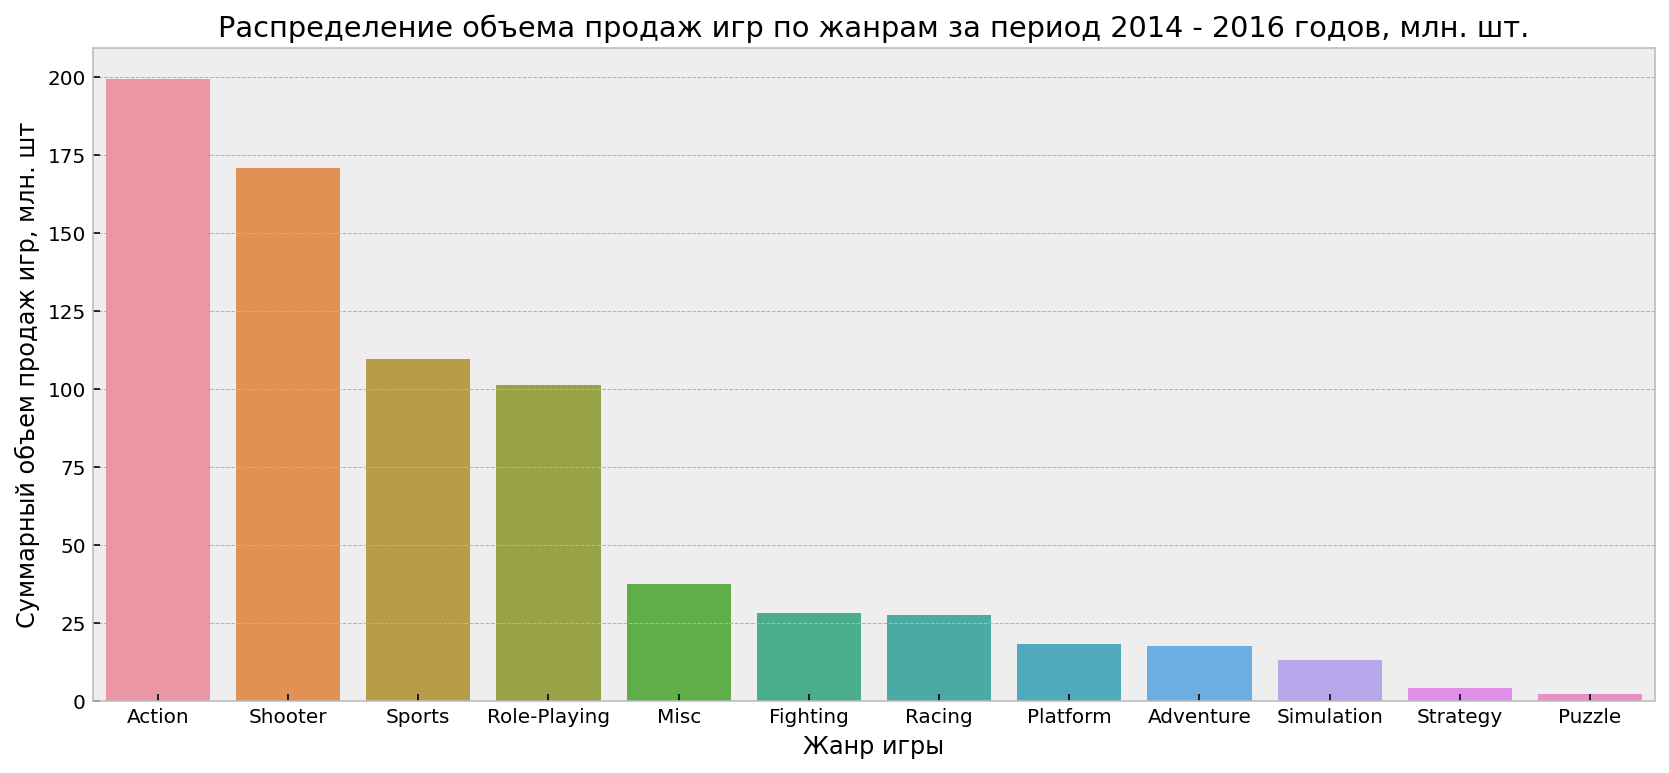

In [76]:
sns.barplot(data = relevant_df.groupby('genre', as_index=False) \
                      .agg({'total_sales': 'sum'}) \
                      .sort_values('total_sales', ascending=False) \
                      .reset_index()
                      , x='genre', y='total_sales')
plt.title('Распределение объема продаж игр по жанрам за период 2014 - 2016 годов, млн. шт.')
plt.xlabel('Жанр игры')
plt.ylabel('Суммарный объем продаж игр, млн. шт')
plt.show()
# построим столбчатую диаграмму по распределению суммарного объема продаж игр разных жанров за релевантный период

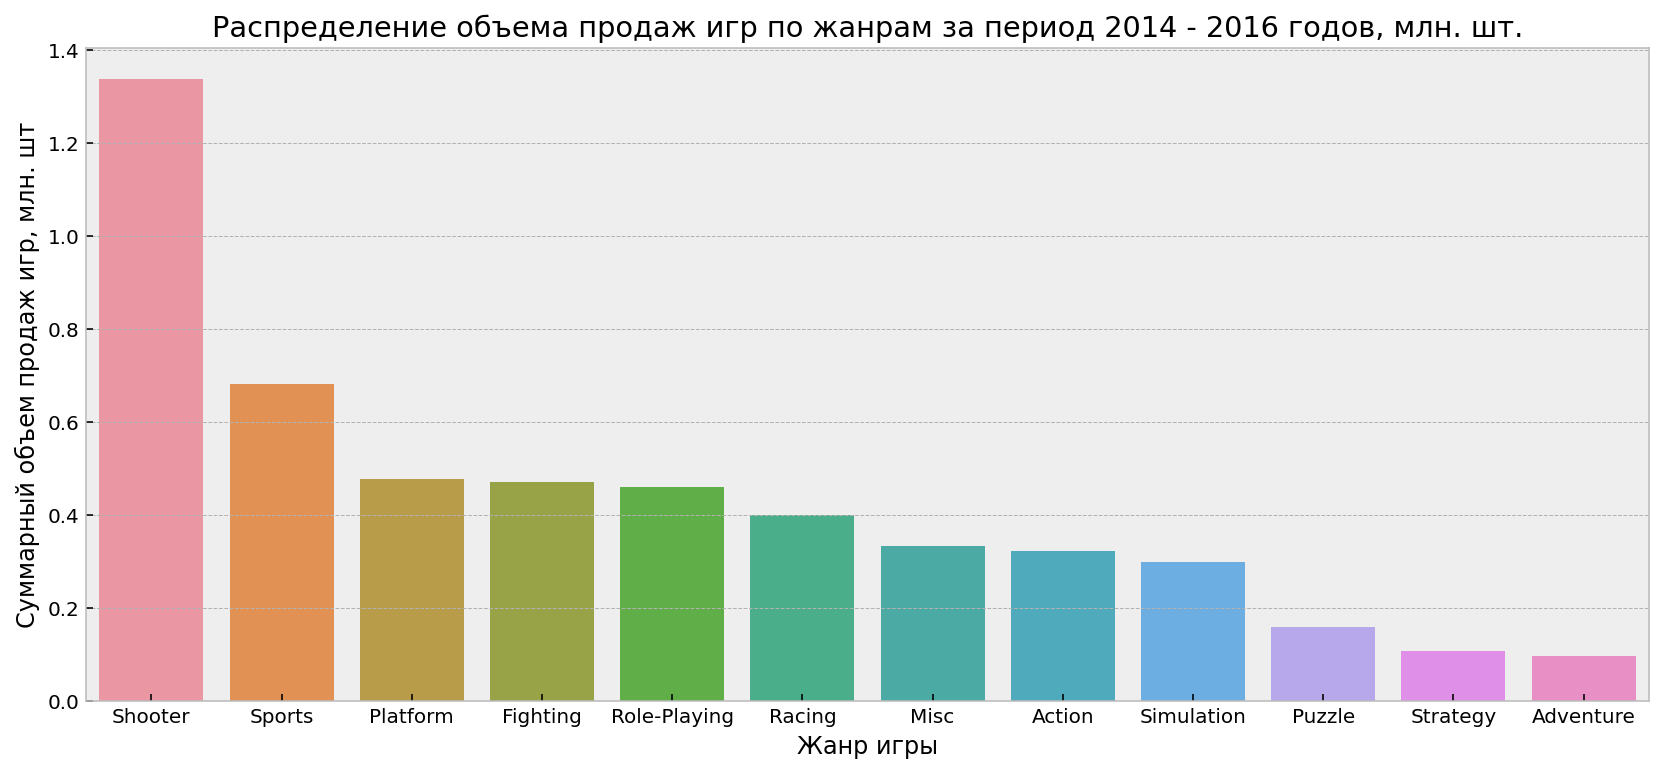

In [77]:
sns.barplot(data = relevant_df.groupby('genre', as_index=False) \
                      .agg({'total_sales': 'mean'}) \
                      .sort_values('total_sales', ascending=False) \
                      .reset_index()
                      , x='genre', y='total_sales')
plt.title('Распределение средневого объема продаж игр по жанрам за период 2014 - 2016 годов, млн. шт.')
plt.xlabel('Жанр игры')
plt.ylabel('Суммарный объем продаж игр, млн. шт')
plt.show()
# построим столбчатую диаграмму по распределению суммарного объема продаж игр разных жанров за релевантный период

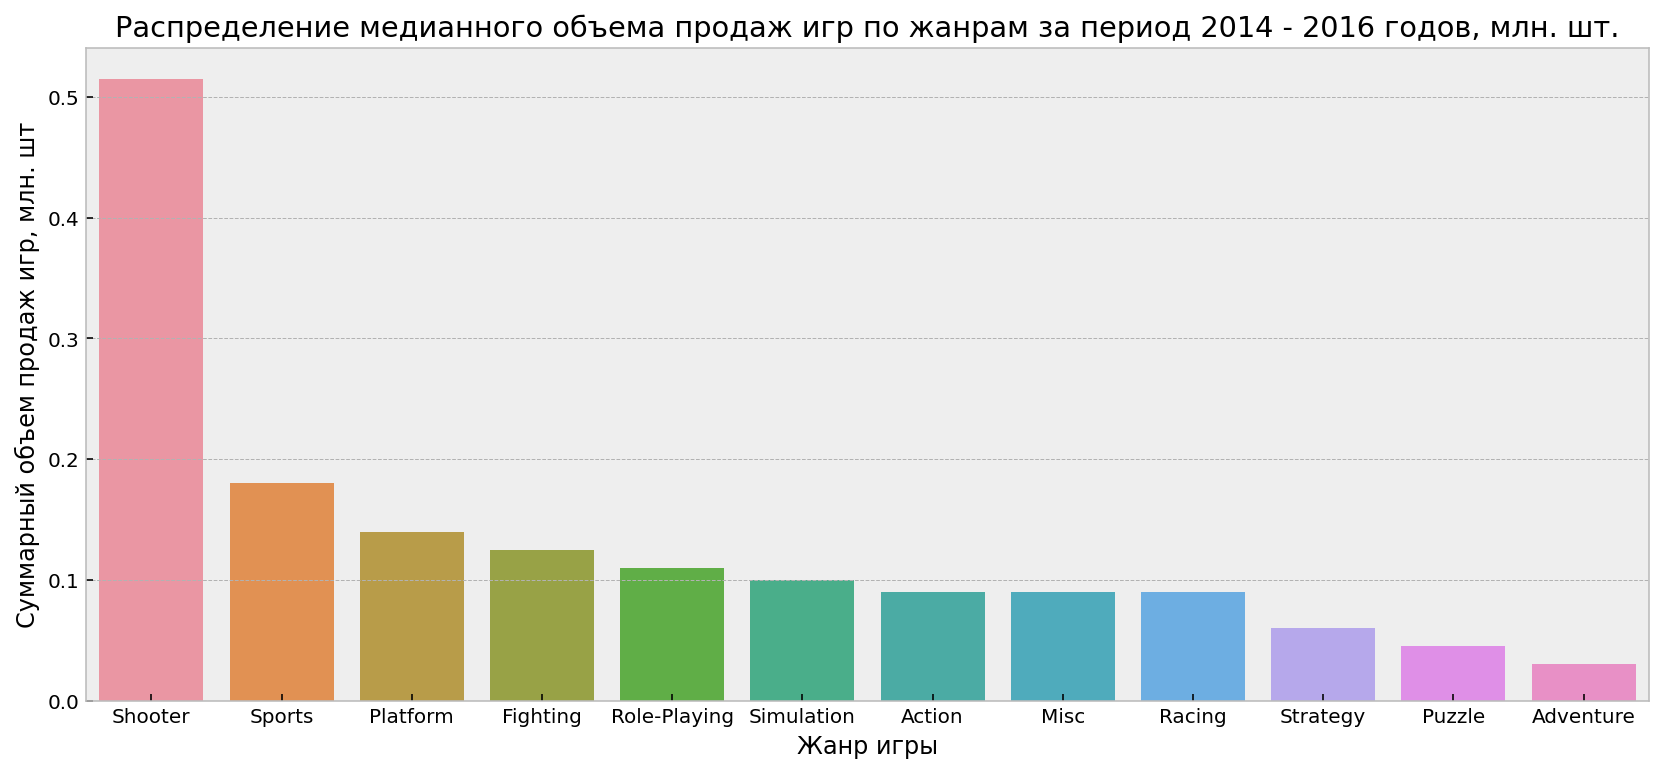

In [79]:
sns.barplot(data = relevant_df.groupby('genre', as_index=False) \
                      .agg({'total_sales': 'median'}) \
                      .sort_values('total_sales', ascending=False) \
                      .reset_index()
                      , x='genre', y='total_sales')
plt.title('Распределение медианного объема продаж игр по жанрам за период 2014 - 2016 годов, млн. шт.')
plt.xlabel('Жанр игры')
plt.ylabel('Суммарный объем продаж игр, млн. шт')
plt.show()
# построим столбчатую диаграмму по распределению суммарного объема продаж игр разных жанров за релевантный период

<div class="alert alert-info">
    <h3> Комментарий к новым столбчатым диаграмма по объему продаж игр по жанрам: <a class="tocSkip"> </h3>
        
**Действительно, суммарные продажи искажают настоящее положение дел, поэтому лучше смотреть либо средние значения (которые тоже не совсем правдивы), либо медианные, анализом этих данных мы сейчас и займемся:**
    <li>
        Сравнивая график средних продаж игр с суммарным, можно отметить следующие моменты:
        <ol start="1">
              <li>Лидер по суммарным продажам - игры жанра "Action" - на самом то деле **в среднем собирают крайне низкие продажи**, поэтому лидерство по общим продажам объясняется тем, что игр данного жанра выходит в разы больше, чем других</li>
              <li>А вот игры жанра "Shooter" - **в среднем набирают очень приличные объемы**, что и позволило им занять  вторую строчку по суммарным продажам и первую по средним</li>
              <li>С большинством остальных популярных жанров ситуация практически аналогичная, как у жанра "Shooter", то есть относительно их суммарного объема продаж, по средним значениям данные жанры занимают +/- те же строчки в рейтинге, однако жанры "Role-Playing" и "Platform" немного выбиваются из данного тренда, про них и поговорим далее</li>
            <li>Так игры жанра "Role-Playing" - **в среднем собирают более низкие продажи** чем их "соседи" по рейтингу суммарных продаж, что говорит нам о том6 что игр этого жанра выходит побольше, чем "жанров-соседей"</li>
            <li>А вот с играми **жанра "Platform" ситуауция обратная** - при относительно небольших объемах суммарных продаж, средние продажи у этих очень даже приличные - что может говорить о том, что игр таких выходило не очень много в сравнении с теми же жанрами "Sports" или же "Role-Playing"</li>
        </ol>
    </li>
    <li>**А график медианных продаж показал, что на самом то деле, в индустрии разрабтки игр крайне редко бывает, что игры набирают +/- одни и те же продажы, а скорее, наоборот - есть длинный хвост из игр с относительно небольшим объемом продаж и лидеры жанров, которые и делают тот или иной жанр более популярным**</li>
</div>

### Итоги исследовательского анализа данных

Подводя итог этапу исследовательского анализа данных, стоит отметить следующие моменты:

- определен пик развития гейм-дев индустрии, связанные с распространеннием электроники в массы, за счет **снижения стоимости продукции**
- построены диаграммы объема выпускаемых игр по платформам после **2000-ых**, что позволило выяснить средний срок жизни платформы - **6-8 лет**, далее производители консолей выпускали новую версию продукта, на которую переключалась бОльшая часть аудитории и привлекала еще больше людей и новые сегменты игроков
- построены графики продаж игр по платформам за релевантный период (**2014 - 2016 года**), где наибольшая волатильность в продажах наблюдальс у продуктов компании Sony - PS 4 и PS 3 - а у XOne и X360 продажи были менее волатильные
- однако ключевым фактором возникновения данного являения является то, что у PS 4 и PS 3 продажи были выше, чем у XOne и X360 соответсвенно, в рассматриваемого периоде, то есть здесь имеет место эффект низкой (маленькой) базы
- а столь резкое падение в 2016 году, скорее всего, объясняется тем, что в дата фрейме **отсутствуют полные данные 2016 года**
- говоря об влиянии разных факторов на объем продаж игр, было изучено влияние оценок пользователей и критиков
- можно с уверенностью сказать, что **оценки критиков имеют большее влияние, нежели оценки игроков**, это можно было увидеть и на диаграммах рассеивания и по коэффициентам корреляции для разных платформ
- этому есть и множество причин, например, наиболее банальная - **они более объективные**
- в целом, оценки критиков и пользователей по платформам не сильно разняться, за исключением одной выбивающейся платформы - **3DS**, у нее у единственной оценки игроков положительно связаны с объемом продаж, так еще эта связь сильнее среди всех связей между оценками пользователей и объемом продаж (**0.22**), а положительные связи умеренные силы между оценками критиков и объемом продаж игры для платформ: **PS4, XOne и PS3 больше "0.4"**, однако для "выбивающейся "консоли - 3DS - лишь **"0.31"**
- наиболее прибыльные жанры - **"Action" и "Shooter"** - приносят **больше половины продаж**
- **более 100 млн.** проданных копий за 2014 - 2016 года имеют лишь 4 жанра, помимо вышеупомянутых жанров это **"Sports" и "Role-Playing"**
- продажы самого популярного жанра ("Action") превысили продажи наименее популярного ("Puzzle") **более чем в 90 раз**
- это объясняется тем, что игры наиболее популярных жанров сложно разработать для других видов дейвайсов, а аудитория наименее продаваемых жанров игр на консолях просто напросто играет на других устройствах - наиболее удобных для них - например, мобильных
- однако игры жанра "Action" - на самом то деле **в среднем собирают крайне низкие продажи**, поэтому лидерство по общим продажам объясняется тем, что игр данного жанра выходит в разы больше, чем других
- А график медианных продаж показал, что на самом то деле, в индустрии разрабтки игр крайне редко бывает, что игры набирают +/- одни и те же продажы, а скорее, наоборот - есть длинный хвост из игр с относительно небольшим объемом продаж и лидеры жанров, которые и делают тот или иной жанр более популярным

## Составление портретов пользователей по регионам

**Для начала мы изучим популярность платформ по регионам**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '3DS'),
  Text(0, 1, 'PS4'),
  Text(0, 2, 'PSV'),
  Text(0, 3, 'PS3'),
  Text(0, 4, 'WiiU'),
  Text(0, 5, 'PSP'),
  Text(0, 6, 'XOne'),
  Text(0, 7, 'X360'),
  Text(0, 8, 'PC'),
  Text(0, 9, 'Wii')])

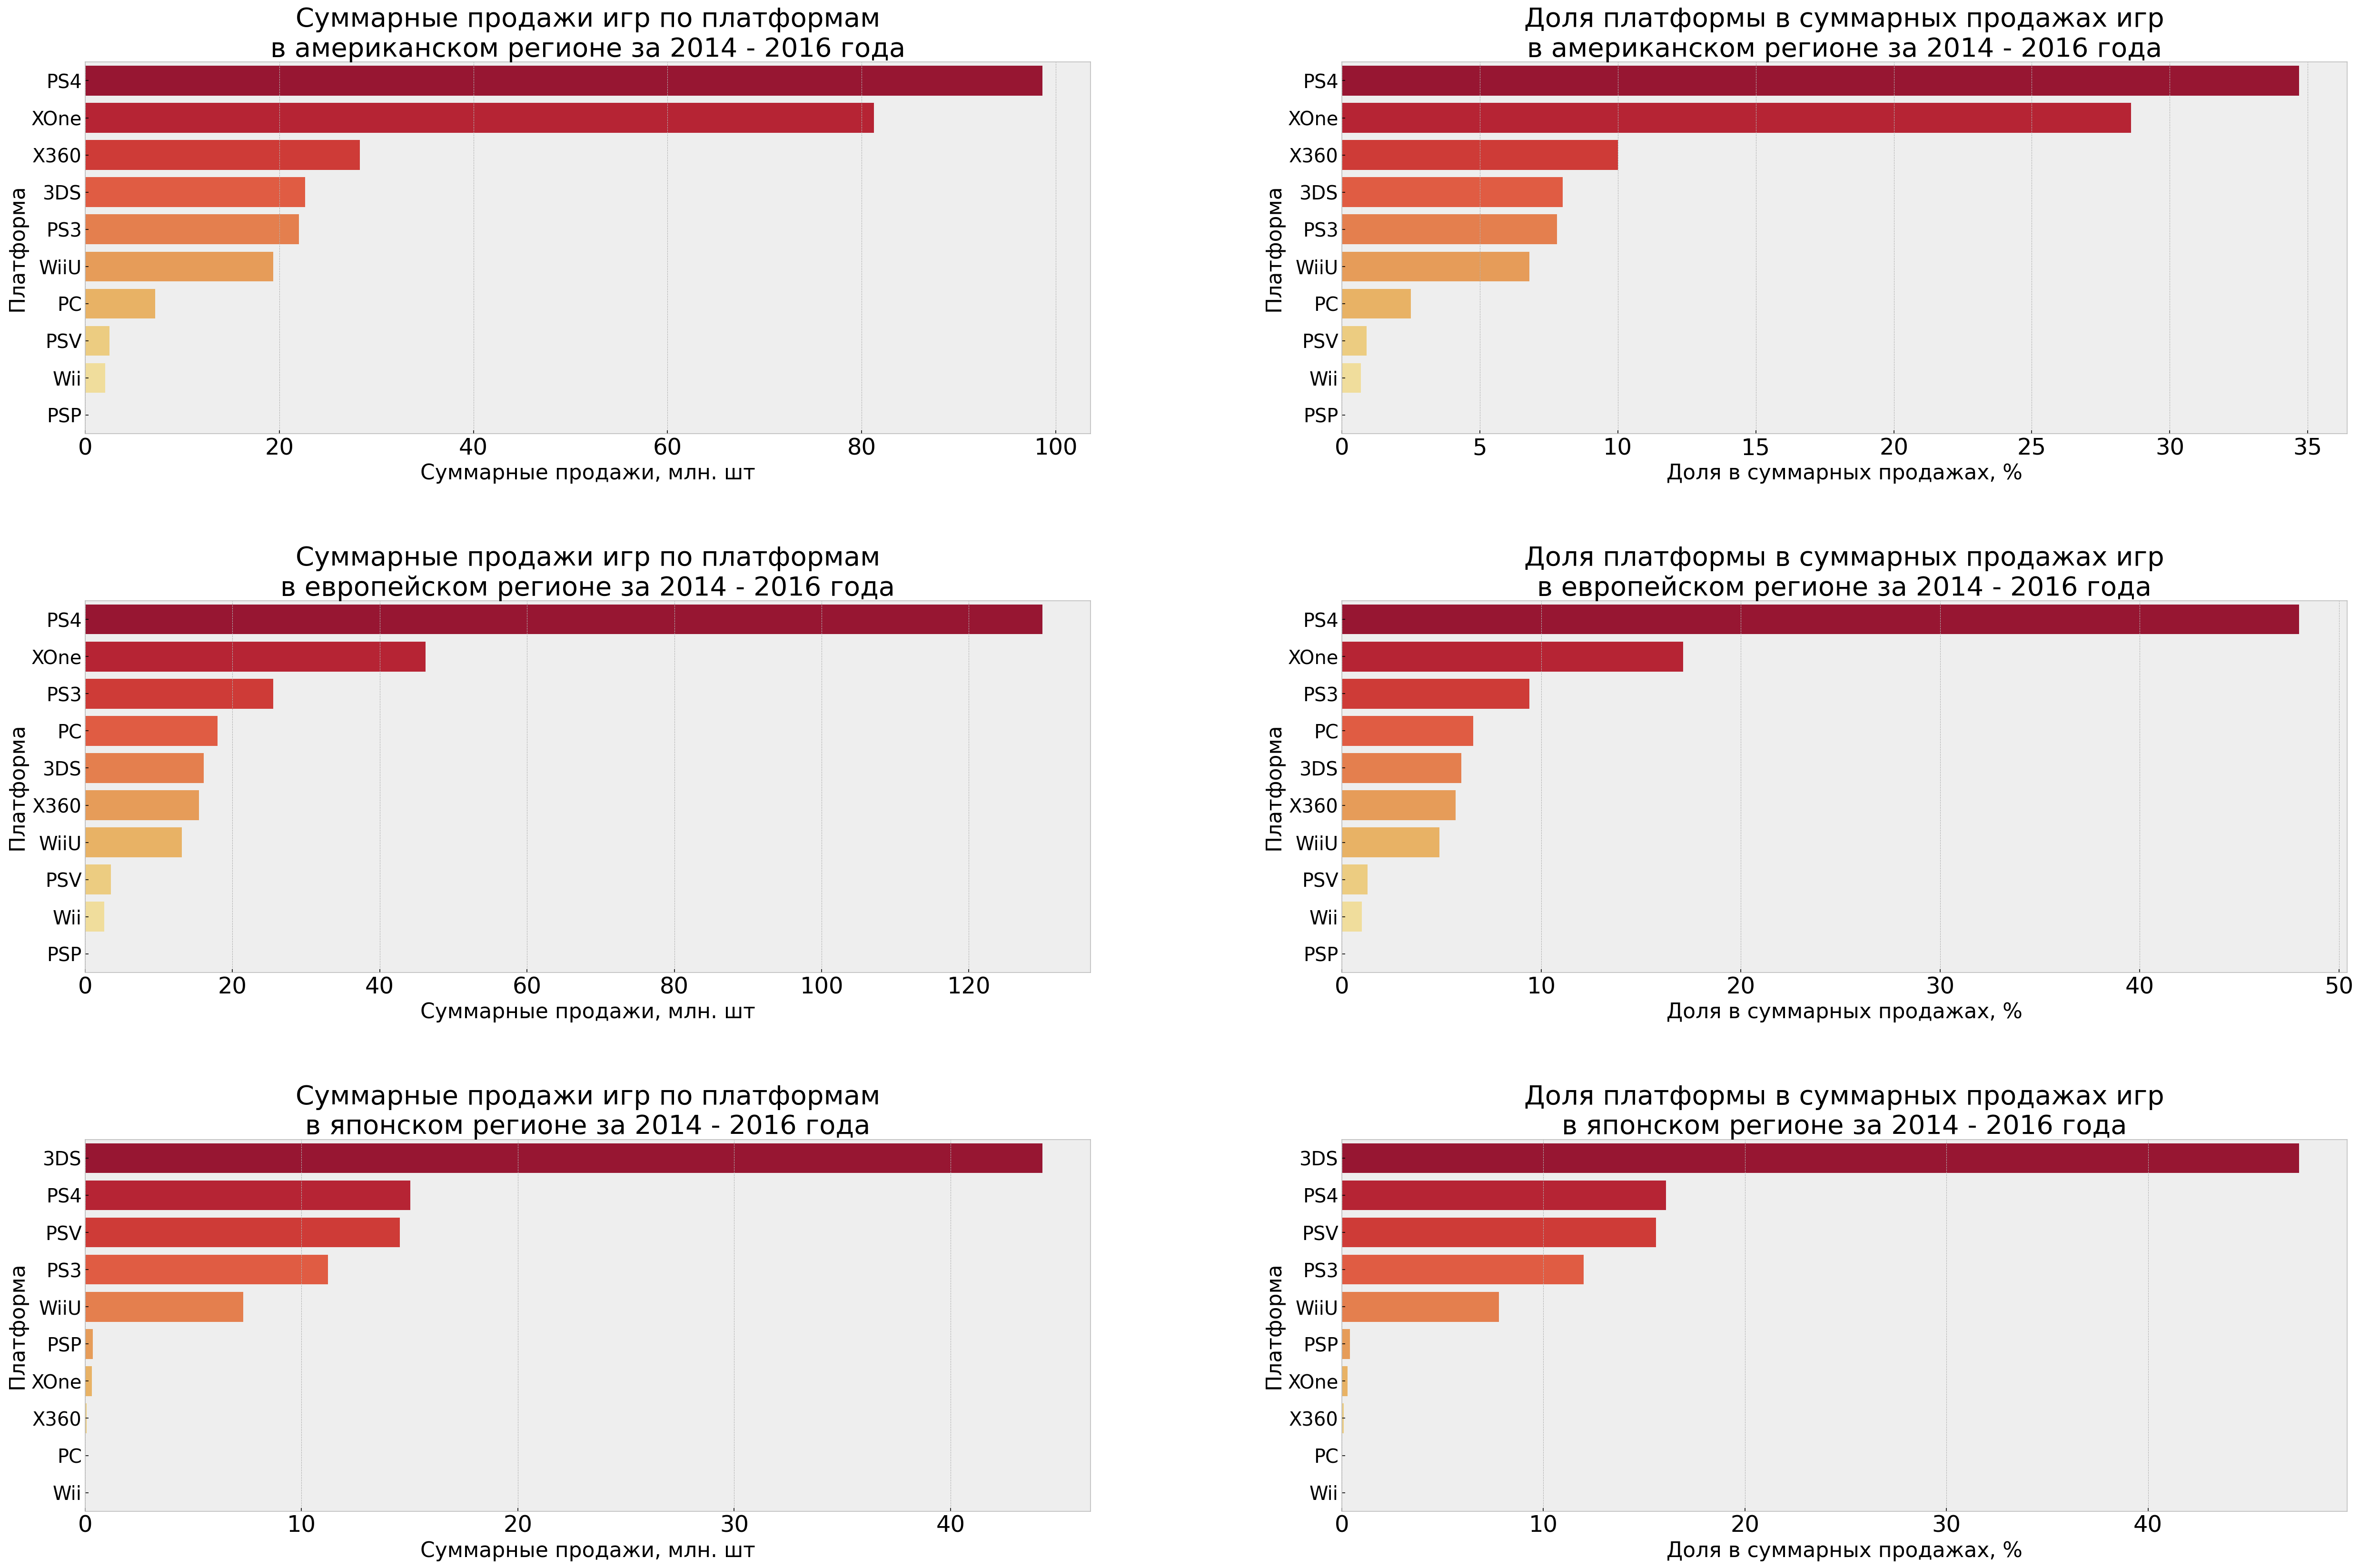

In [59]:
fig=plt.figure(figsize=(44,28))
plt.subplots_adjust(left=0.15, wspace=0.25, hspace=0.45)

plt.subplot(3, 2, 1)
plt.title('Суммарные продажи игр по платформам\nв американском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.groupby('platform').sum()['na_sales'] \
                            .sort_values(ascending=False) \
                            .reset_index() \
           , x='na_sales', y='platform', palette='YlOrRd_r');
plt.ylabel('Платформа', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(3, 2, 2)
plt.title('Доля платформы в суммарных продажах игр\nв американском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=(round(relevant_df.groupby('platform').sum()['na_sales'] \
                      / relevant_df.groupby('platform').sum().sum()['na_sales'], 3) * 100) \
                                   .to_frame() \
                                   .reset_index() \
                                   .sort_values('na_sales', ascending=False) \
                     , x='na_sales', y='platform', palette='YlOrRd_r');
plt.ylabel('Платформа', fontdict={'fontsize':22})
plt.xlabel('Доля в суммарных продажах, %', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(3, 2, 3)
plt.title('Суммарные продажи игр по платформам\nв европейском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.groupby('platform').sum()['eu_sales'] \
                            .sort_values(ascending=False) \
                            .reset_index() \
           , x='eu_sales', y='platform', palette='YlOrRd_r');
plt.ylabel('Платформа', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(3, 2, 4)
plt.title('Доля платформы в суммарных продажах игр\nв европейском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=(round(relevant_df.groupby('platform').sum()['eu_sales'] \
                      / relevant_df.groupby('platform').sum().sum()['eu_sales'], 3) * 100) \
                                   .to_frame() \
                                   .reset_index() \
                                   .sort_values('eu_sales', ascending=False) \
                     , x='eu_sales', y='platform', palette='YlOrRd_r');
plt.ylabel('Платформа', fontdict={'fontsize':22})
plt.xlabel('Доля в суммарных продажах, %', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(3, 2, 5)
plt.title('Суммарные продажи игр по платформам\nв японском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.groupby('platform').sum()['jp_sales'] \
                            .sort_values(ascending=False) \
                            .reset_index() \
           , x='jp_sales', y='platform', palette='YlOrRd_r');
plt.ylabel('Платформа', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(3, 2, 6)
plt.title('Доля платформы в суммарных продажах игр\nв японском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=(round(relevant_df.groupby('platform').sum()['jp_sales'] \
                      / relevant_df.groupby('platform').sum().sum()['jp_sales'], 3) * 100) \
                                   .to_frame() \
                                   .reset_index() \
                                   .sort_values('jp_sales', ascending=False) \
                     , x='jp_sales', y='platform', palette='YlOrRd_r');
plt.ylabel('Платформа', fontdict={'fontsize':22})
plt.xlabel('Доля в суммарных продажах, %', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)
# строим столбчатые диаграммы суммарных продаж игр на разных платформамх, а также доли каждой платформы в них
# по регионам за релевантный период

**Комментарий к полученным столбчатым диаграммам:**

- на рынках **Европы и Северной Америки** консоли от Sony являются безоговорочными лидерами, продажи что у **PS 4 больше, чем у XOne, что у PS 3, чем у X360** (только на европейском рынке) (применяется подобное сравнение поскольку вышеуказанные консоли выходили +/- в одно и то же время), однако на рынке Японии дела обстоят инчае
- несмоторя на то, что и Sony, и Nintendo - японские компании, и казалось бы, в штате сотрудников обеих фирм есть немалая доля работников, отлично понимающих менталитет, ценности и прочие вещи важные для успеха на отдельно взятом локальном рынке, но в **Японии** безусловный лидер - Nintendo со своей консолью **3DS**
- объяснить вышеописанную ситуацию можно тем, что компания Sony просто поставила приоритеты на более масшатбные рынки такие, как Европейский и Американский (что и видно из графиков)
- переходя к рассмотрению каждого рынка по отелдльности, начнем с рассмотрения американского региона, на данном рынке наибольшую долю имеет **PS 4** - практически **35%**, ближайший преследователь - **XOne** с долей порядка **28%**
- рассматривая рынок Европы, то на нем доманиция **PS 4** еще сильнее - доля практически **50%**, а у **XOne** - лишь порядка **17%**, более того, предыдущая версия консоли от Sony занимает третью строчку по размеру доли с практически **10%** рынка, в то время, как у **X360** порядка **5%**
- как и говорилось ранее, **рынок Японии** является в своем роде **"особенным"** - здесь в лидерах мы не увидим ни консоли от Sony, ни от Microsoft (XOne и X360), безоговорочным фаворитом среди японцев является консоль от отечественной компании - **3DS** с более чем **45%** доли рынка, а у лидера европейского и американского рынков (PS 4) - скромные 15%, но есть пара моментов
- а именно на рынке Японии на продукты компании Sony приходится порядка **43%**, что не сильно меньше, чем на американском **(~ 46%)** и прилично отстает от основого рныка - европейского **(~ 55-56%)**, поэтому предположение, выдвинутое во втором пункте данного комментария - ошибочно
- это может объясняться тем, что тип потребления (в каких местах играют) на рынке Японии отличается от других рынков или же просто уровень платежоспособности аудитории игр для цифровых устройств в период 2014 - 2016 годов в Японии был ниже, чем на других рынках
- однако американская компания на рынке Японии потерпела тотальное поражение с обоими своими продуктами, совокупная доля продаж игр на эти платформы **менее 2%**

**Далее рассмотрим продажи по жанрам в разных регионах**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Action'),
  Text(0, 1, 'Shooter'),
  Text(0, 2, 'Sports'),
  Text(0, 3, 'Role-Playing'),
  Text(0, 4, 'Misc'),
  Text(0, 5, 'Fighting'),
  Text(0, 6, 'Racing'),
  Text(0, 7, 'Platform'),
  Text(0, 8, 'Adventure'),
  Text(0, 9, 'Simulation'),
  Text(0, 10, 'Strategy'),
  Text(0, 11, 'Puzzle')])

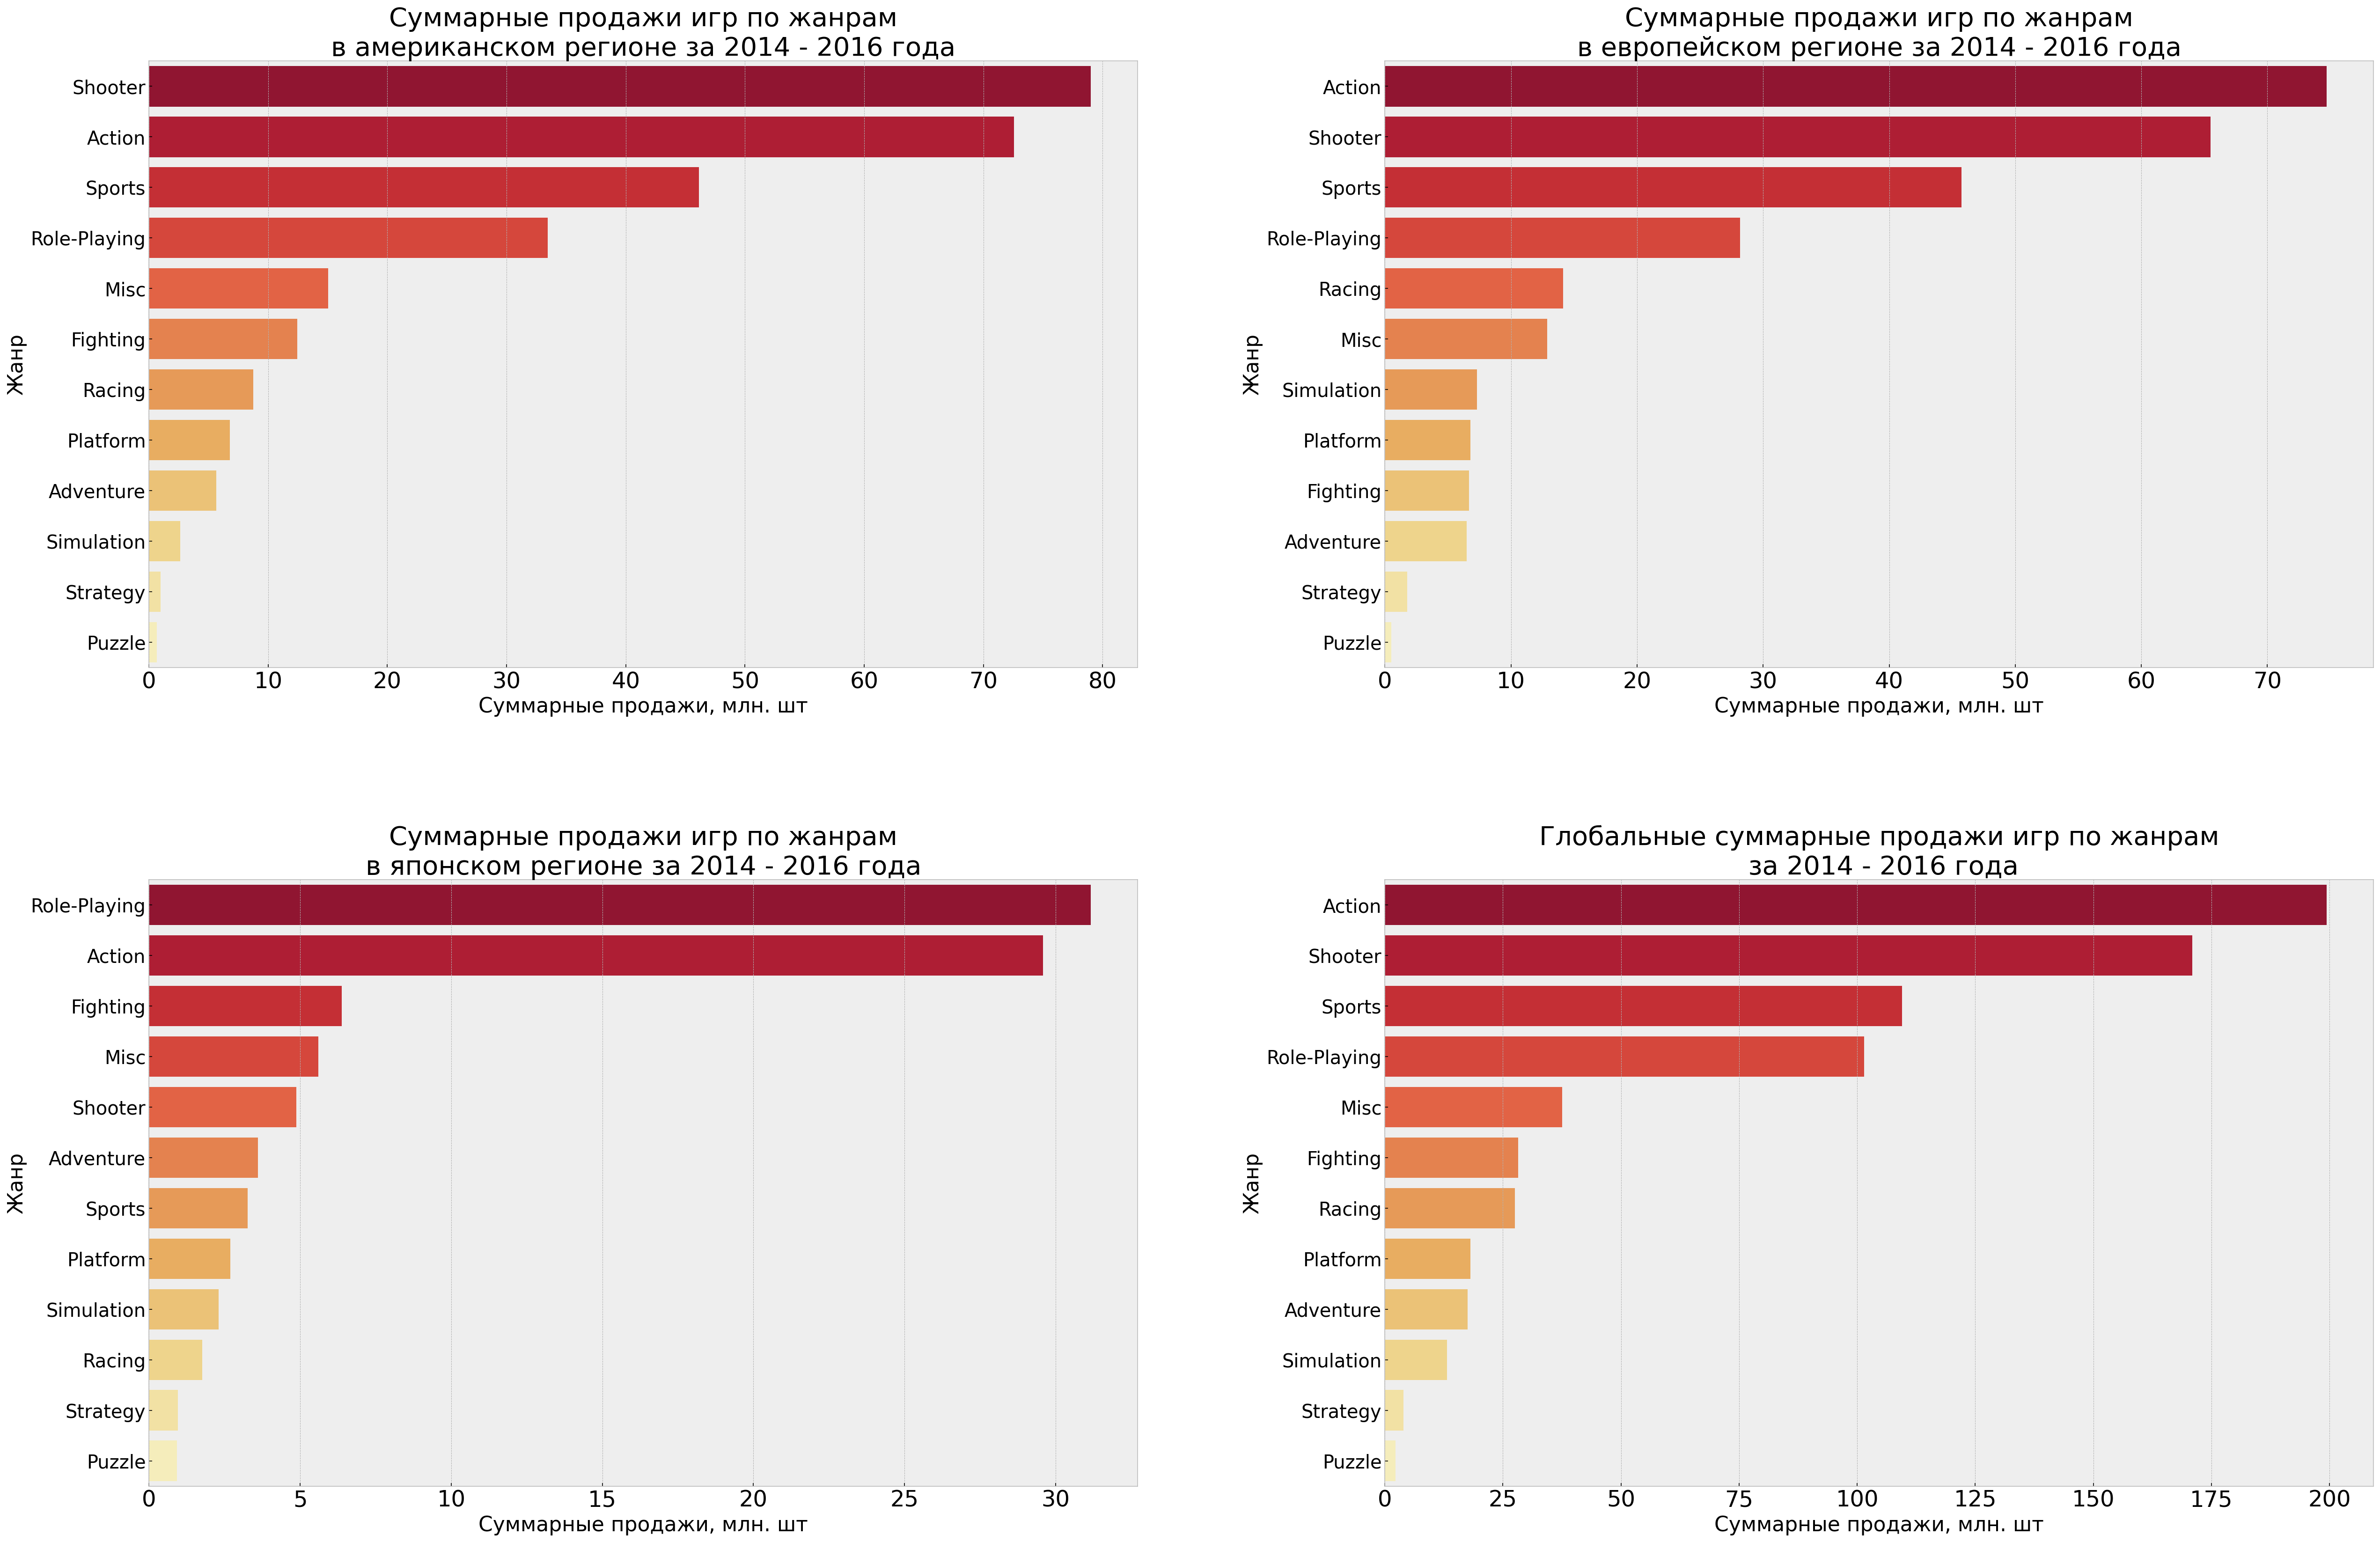

In [60]:
fig=plt.figure(figsize=(44,28))
plt.subplots_adjust(left=0.15, wspace=0.25, hspace=0.35)

plt.subplot(2, 2, 1)
plt.title('Суммарные продажи игр по жанрам\nв американском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.groupby('genre').sum()['na_sales'] \
                            .sort_values(ascending=False) \
                            .reset_index() \
           , x='na_sales', y='genre', palette='YlOrRd_r');
plt.ylabel('Жанр', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(2, 2, 2)
plt.title('Суммарные продажи игр по жанрам\nв европейском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.groupby('genre').sum()['eu_sales'] \
                            .sort_values(ascending=False) \
                            .reset_index() \
           , x='eu_sales', y='genre', palette='YlOrRd_r');
plt.ylabel('Жанр', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(2, 2, 3)
plt.title('Суммарные продажи игр по жанрам\nв японском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.groupby('genre').sum()['jp_sales'] \
                            .sort_values(ascending=False) \
                            .reset_index() \
           , x='jp_sales', y='genre', palette='YlOrRd_r');
plt.ylabel('Жанр', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(2, 2, 4)
plt.title('Глобальные суммарные продажи игр по жанрам\n за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.groupby('genre').sum()['total_sales'] \
                            .sort_values(ascending=False) \
                            .reset_index() \
           , x='total_sales', y='genre', palette='YlOrRd_r');
plt.ylabel('Жанр', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

**Комментарий к полученным столбчатым диаграммам:**

- в общем и целом, **рынки Европы и Северной Америки можно сказать идентичны**, то есть предпочтения у людей, проживающих / играющих в данных регионах схожи
- наиболее значимое отличе - на европейском рынке лидер - игры жанра **"Action"**, а на американском - **"Shooter"**
- суммарные продажи продажи двух вышеупомянутых жанров состовляют **более 50%**, и на американском, и на европейском рынках, **около 53,4% и 51,8%** соответственно
- в остальном рынки практически идентичны, естественно, присутсвуют небольшие отличия в продажах на американском рынке всех остальных жанров в сравнении с европейским, однако они не столь значительны
- на рынке **Японии** и в этот раз не обошлось без сюрпризов - лидер продаж - игры жанра **"Role-playing"**, а лидер европейского рынка - игры жанра **"Action"** - расположился на 2 строчке, в то время, как - американского - лишь на **4 строчке**
- доля продаж игр жанра **"Role-playing"** - **более 33%**, **"Action"** - практически **32%**, а у **"Shooter"** скромные **5,2%
- в целом, на мировые продажи ситуация на японском рынке кординальных изменений не оказали, поскольку **топ-4** жанра идентичны **европейскому рейтингу**, однако **культурные особенности и ценности**, безусловно, влияют на популярность игры в конкретном регионе

**Далее определим влияние рейтинга ESRB на продажи игр в разных регионах**

(array([0, 1, 2, 3]),
 [Text(0, 0, 'M'), Text(0, 1, 'E'), Text(0, 2, 'T'), Text(0, 3, 'E10+')])

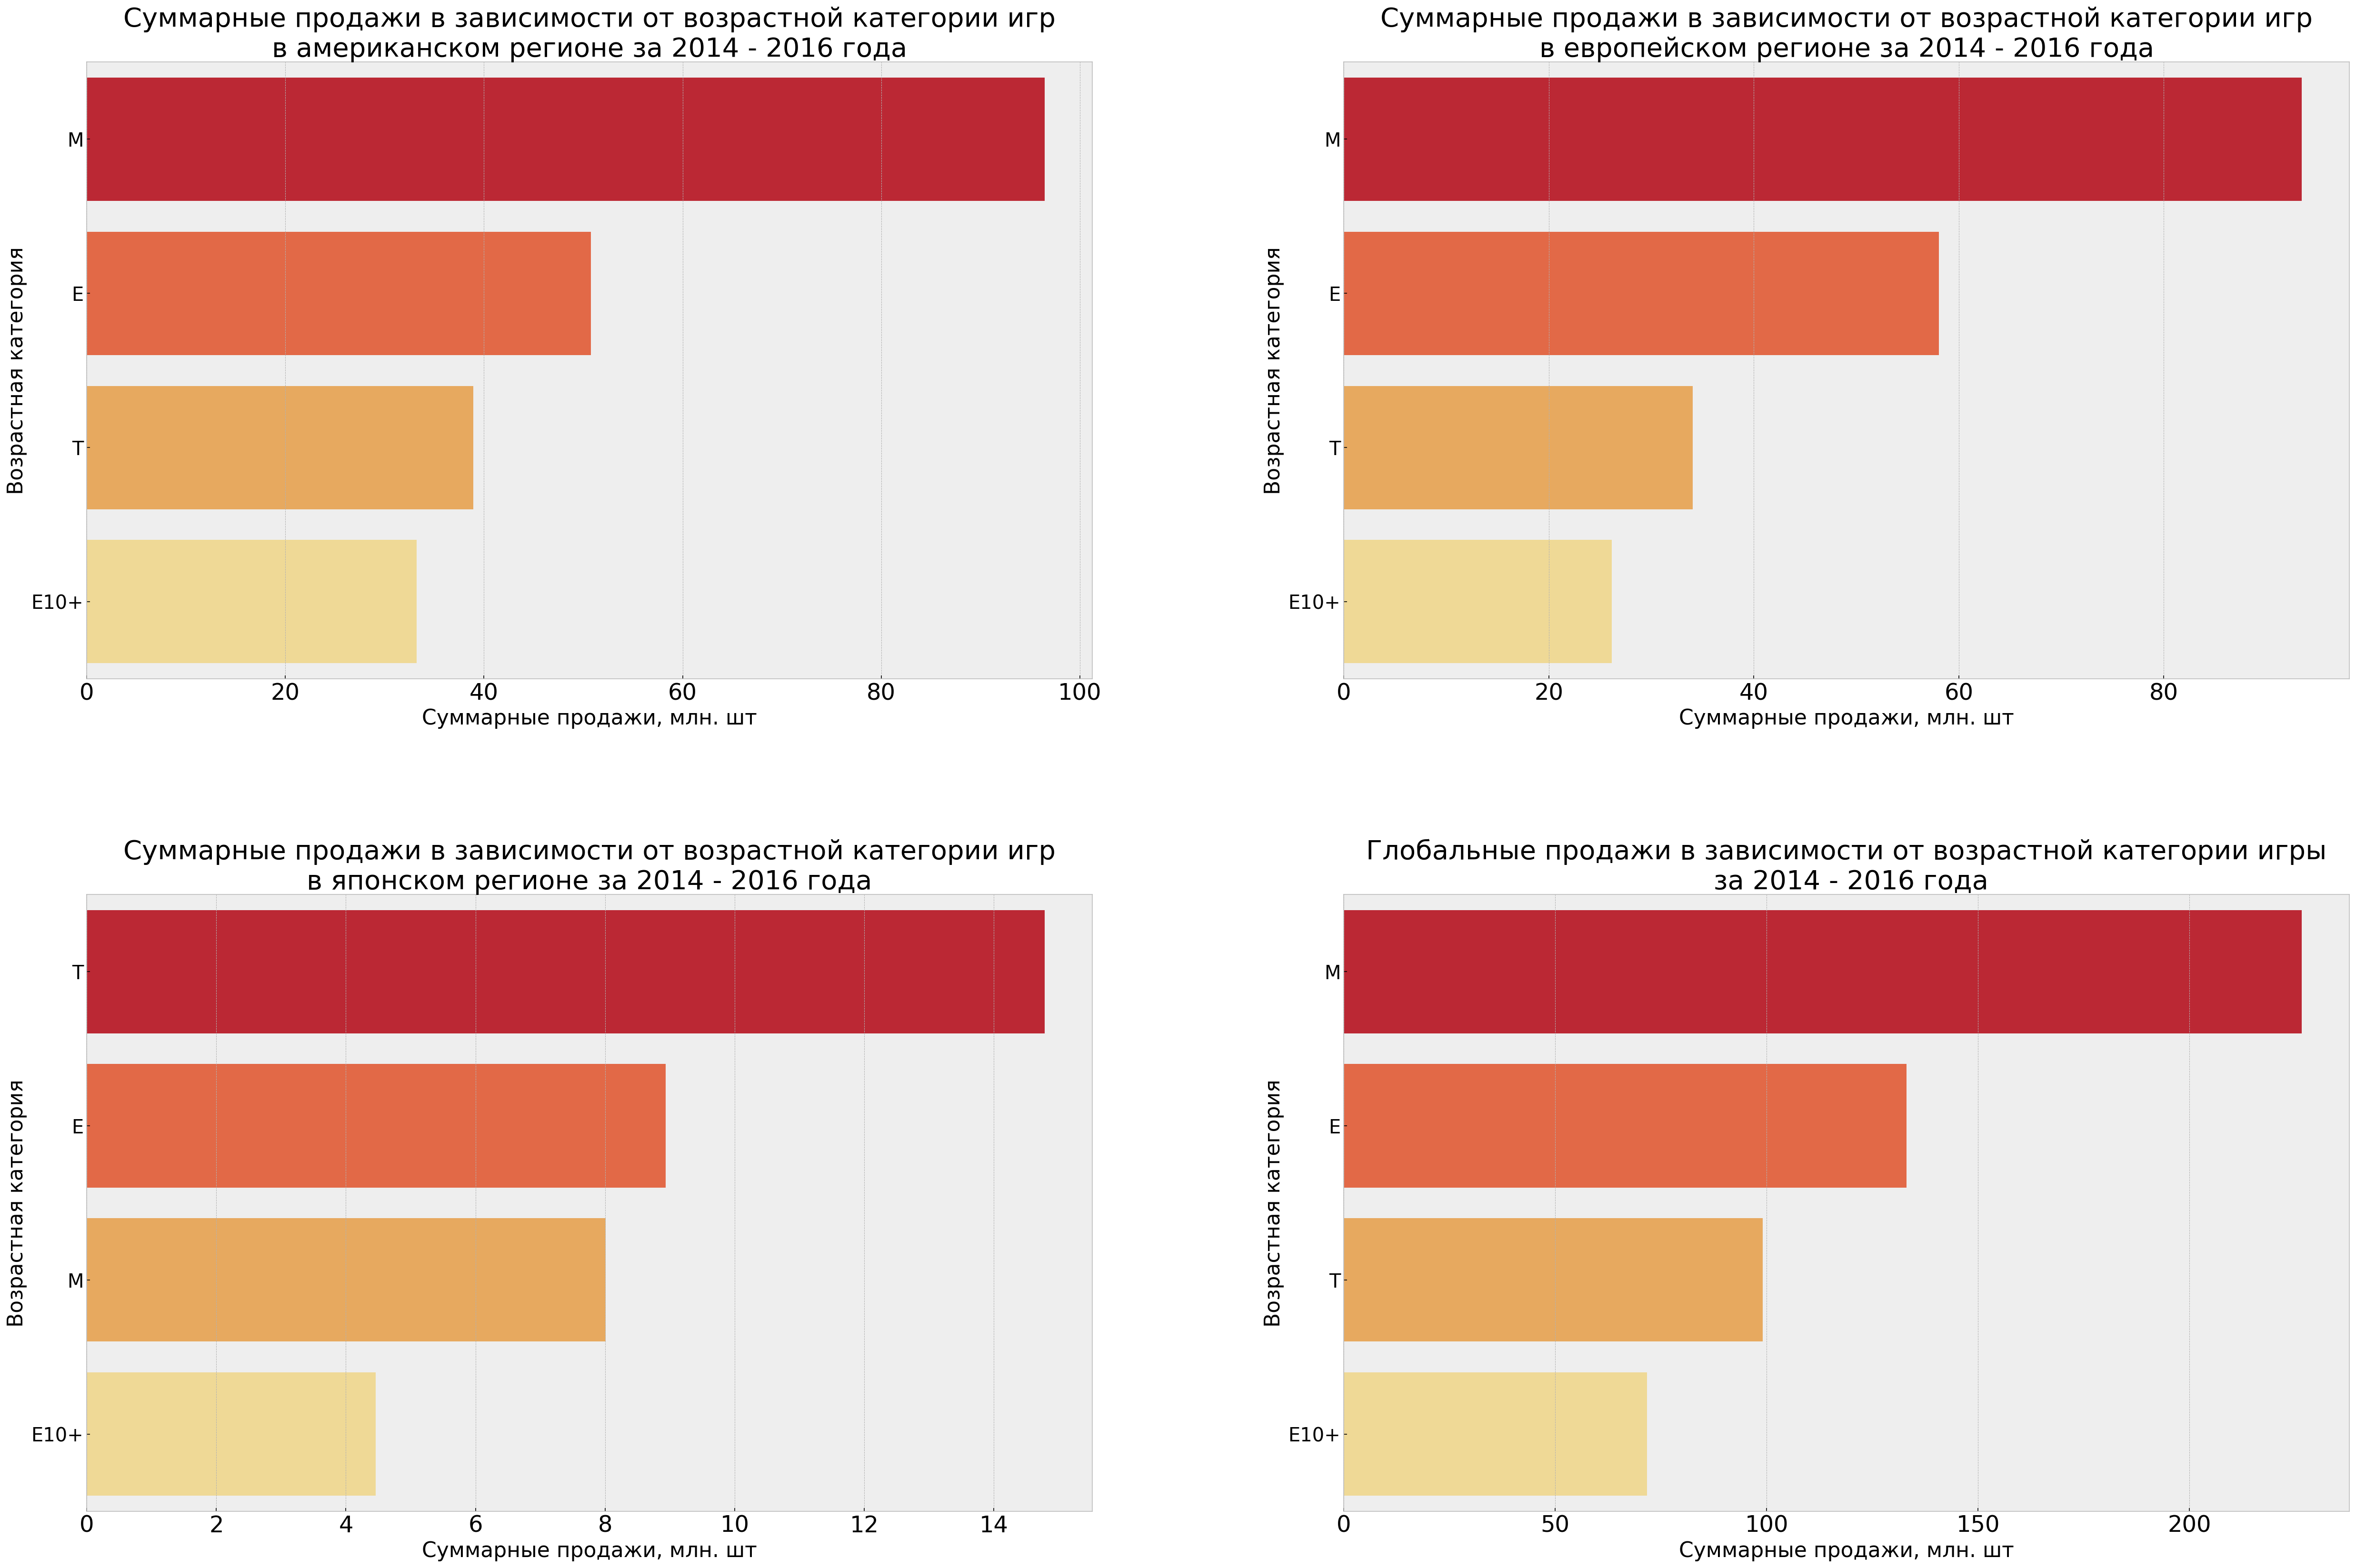

In [61]:
fig=plt.figure(figsize=(44,28))
plt.subplots_adjust(left=0.15, wspace=0.25, hspace=0.35)

plt.subplot(2, 2, 1)
plt.title('Суммарные продажи в зависимости от возрастной категории игр\nв американском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.query('rating != "None"') \
                            .groupby(['rating'], as_index=False).sum() \
                            .sort_values('na_sales', ascending=False) \
            , x='na_sales', y='rating', palette='YlOrRd_r');
plt.ylabel('Возрастная категория', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(2, 2, 2)
plt.title('Суммарные продажи в зависимости от возрастной категории игр\nв европейском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.query('rating != "None"') \
                            .groupby(['rating'], as_index=False).sum() \
                            .sort_values('eu_sales', ascending=False) \
            , x='eu_sales', y='rating', palette='YlOrRd_r');
plt.ylabel('Возрастная категория', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(2, 2, 3)
plt.title('Суммарные продажи в зависимости от возрастной категории игр\nв японском регионе за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.query('rating != "None"') \
                            .groupby(['rating'], as_index=False).sum() \
                            .sort_values('jp_sales', ascending=False) \
            , x='jp_sales', y='rating', palette='YlOrRd_r');
plt.ylabel('Возрастная категория', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

plt.subplot(2, 2, 4)
plt.title('Глобальные продажи в зависимости от возрастной категории игры\n за 2014 - 2016 года',fontdict={'fontsize':28})
sns.barplot(data=relevant_df.query('rating != "None"') \
                            .groupby(['rating'], as_index=False).sum() \
                            .sort_values('total_sales', ascending=False) \
            , x='total_sales', y='rating', palette='YlOrRd_r');
plt.ylabel('Возрастная категория', fontdict={'fontsize':22})
plt.xlabel('Суммарные продажи, млн. шт', fontdict={'fontsize':22})
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)

**Для справки**

1. категория "E10+" - это игры для детей старше 10 лет
2. категория "T" - это игры для детей старше 13 лет
3. категория "M" - это игры для людей старше 17 лет 
4. категория "E" - это игры для людей любого возраста

**Комментарий к полученным столбчатым диаграммам:**

- стоит заметить, что при построении графика **НЕ учитывались** игры без возрастной категории, это довольно-таки важное замечание, поскольку всего таких игр в нашем изначальном дата фрейме было порядка **6700**
- категория
- в общем и целом, ситуация схожа с тем, что мы наблюдали в распределении жанров по популярности, а именно 
- **рынки Европы и Северной Америки можно сказать идентичны**, то есть предпочтения у людей, проживающих / играющих в данных регионах схожи - топ-4 возрастных категорий полностью совпадает
- игры категории **"M"** имеют около **50%** доли продаж на рынках **Америки и Европы**, а в абсолютном выражении это порядка **95 и 90 млн. шт.** соответственно
- игры категорий **"E", "T" и "E10+"** делят оставшиеся 50% рынка между собой и на рынке **Америки** имеют продажи порядка **50, 39 и 33 млн. копий**, а на **европейском** - **59, 34 и 27 млн. ед.** соответственно
- а на рынке Японии опять же есть свои особенности - наибольшую популярность имеют игры категории **"T"** с примерно **49-50% долей** или же **15 млн. копий**
- на второй строчке, так же как и в Америки и Европе, занимают игры категории **"E"** с объемом продаж в **9 млн. ед.**
- а лидер рынков западных рынков - категория **"M"** - занимает лишь 3 строчку с **8 млн.** проданных копий, что соответствует примерно **25% доли рынка**
- а ситуация по глобальным продажам опять же идентична западному рынка, поскольку он гораздо больше, чем рынок Японии
- таким образом, можно утверждать, что в **Японии** больше всего играют в игры для **подростков**, а в **мире** - для **взрослых** (нельзя с уверенностью утверждать, что все люди прислушиваются к рекомендациям от Entertainment Software Rating Board и, например, покупают своим детям только те игры, которые соответствуют их возрасту)
- такой феномен в Японии можно объяснить культырными и моральными ценностями населения

### Итоги портретов пользователей по регионам

Изучив особенности разных рынков, стоит отметить следующие моменты:

- западные рынки во многом схожи:
1. и в Северной Америке, и в Европе консоли от **Sony** занимают доминирующее положение, далее идут продукты от **Microsoft**
2. суммарные продажи продажи двух наиболее популярных жанров игр - **"Action"** и **"Shooter"** - состовляют **более 50%**, и на американском, и на европейском рынках, **около 53,4% и 51,8%** соответственно
3. игроки предпочитают релизы для **взрослых** (ESRB рейтинг - "M")
- а вот рынок Японии имеет свои особенности в сравнении с западными рынками:
1. несмотря на то, что на рынке Японии первое место занимает продукт от Nintendo - 3DS - с большим отрывом от второго (от PS 4), продукты Sony (PSP, PS3 и PS 4) имеют в сумме **43% рынка**, что не сильно меньше, чем на американском **(~ 46%)** и прилично отстает от основого рныка - европейского **(~ 55-56%)** 
2. наиболее популярным жанром игр среди Японцев является - **"Role-playing"** - их доля продаж **более 33%**, а у лидеров западных рынков **"Action"** - **32%**, у **"Shooter"** скромные **5,2%**
3. больше всего играют в игры для **взрослых** (ESRB рейтинг - "M")
- таким образом, можно сказать, что западный рынок сильно отличается от Японского, однако в разрезе всех продаж - Японии лишь малая часть

## Проверка гипотез

**Далее будут проверяться следующие предположения:**

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action и Sports разные.

**Начнем с первой**

**Гипотеза 1 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

- H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- H1: Средние пользовательские рейтинги платформ Xbox One и PC разные.

In [62]:
from scipy import stats as st 
# импортируем модуль библиотеки scipy для проверки гипотез

In [63]:
XOne_scores = relevant_df.query('platform == "XOne"')['user_score'] \
                       .to_frame() \
                       .query('0 < user_score')
XOne_scores['user_score'].head()
# создаем переменную с пользовательскими оценками игр на XOne

165    7.898438
179    5.398438
241    6.398438
269    6.199219
372    4.101562
Name: user_score, dtype: float16

In [64]:
PC_scores = relevant_df.query('platform == "PC"')['user_score'] \
                           .to_frame() \
                           .query('0 < user_score')
PC_scores['user_score'].head()
# создаем переменную с пользовательскими оценками игр на PC

455     3.900391
1516    5.398438
1710    7.898438
2273    5.699219
2746    5.898438
Name: user_score, dtype: float16

In [65]:
print(f'Средняя оценка игроков игр на XOne: \033[1m{round(XOne_scores["user_score"].mean(), 3)}\033[0m')
print(f'Средняя оценка игроков игр на PC: \033[1m{round(PC_scores["user_score"].mean(), 3)}\033[0m')
# посмотрим на средние оценки по платформам

Средняя оценка игроков игр на XOne: 6.59375
Средняя оценка игроков игр на PC: 6.30078125


**Далее будет проведен T-test**

In [66]:
alpha = .05 # уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(XOne_scores, PC_scores, equal_var=False)
print('p-значение:', results.pvalue[0])
# выводим на экран получившееся p-значение

p-значение: 0.11502406167666081


In [67]:
if results.pvalue[0] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


**Комментарий к проверке гипотезы 1:**

- поскольку p-значение > 0.05, то мы принимаем нулевую гипотезу и отвергаем альтернативную (H1), то есть "средние пользовательские рейтинги платформ Xbox One и PC одинаковые."

**Далее будем проверять гипотезу 2 - Средние пользовательские рейтинги жанров Action и Sports разные**

**Гипотеза 2 - Средние пользовательские рейтинги жанров Action и Sports разные**

- H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые;
- H1: Средние пользовательские рейтинги жанров Action и Sports разные.

In [68]:
Action_scores = relevant_df.query('genre == "Action"')['user_score'] \
                       .to_frame() \
                       .query('0 < user_score')
Action_scores['user_score'].head()
# создаем переменную с пользовательскими оценками игр жанра "Action"

42     8.296875
165    7.898438
230    8.101562
294    6.300781
303    4.898438
Name: user_score, dtype: float16

In [69]:
Sports_scores = relevant_df.query('genre == "Sports"')['user_score'] \
                           .to_frame() \
                           .query('0 < user_score')
Sports_scores['user_score'].head()
# создаем переменную с пользовательскими оценками игр на PC

77     4.300781
94     5.000000
143    5.699219
263    4.500000
313    6.699219
Name: user_score, dtype: float16

In [70]:
print(f'Средняя оценка игроков игр жанра "Action": \033[1m{round(Action_scores["user_score"].mean(), 3)}\033[0m')
print(f'Средняя оценка игроков игр жанра "Sports": \033[1m{round(Sports_scores["user_score"].mean(), 3)}\033[0m')
# посмотрим на средние оценки по платформам

Средняя оценка игроков игр жанра "Action": 6.76171875
Средняя оценка игроков игр жанра "Sports": 5.22265625


**Уже на данном этапе стоит задуматься об истинности нулевой гипотезы:**

- поскольку видно, что средние не равны

**Далее будет проведен T-test**

In [71]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results2 = st.ttest_ind(Action_scores, Sports_scores, equal_var=False)
print('p-значение:', results2.pvalue[0])
# выводим на экран получившееся p-значение

p-значение: 1.1995952414596665e-14


In [72]:
if results2.pvalue[0] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


**Комментарий к проверке гипотезы 2:**

- поскольку p-значение < 0.05, то мы отвергли нулевую гипотезу и приняли альтернативную (H1), то есть - H1: Средние пользовательские рейтинги жанров Action и Sports разные.

### Итоги проверки гипотез

Проведя проверку двух гипотез, мы получили следующие результаты: 

- **Гипотеза 1:"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - подтвердилась"**, поскольку p-value оказалось больше уровеня значимости (0.05)
- **Гипотеза 2:"Средние пользовательские рейтинги жанров Action и Sports разные - подтвердилась"**, пользователи, действительно, по разному оценивают игры жанров "Action" и "Sports", так средняя оценка игр жанра "Action" - **6,76** , а "Sports" - **5,22**

**На этом исследования подошло к концу, а теперь перейдем к самой важной части - выводам**

## Общий вывод

- Рост количества выпускаемых игр начался примерно с **1993 года**, однако до 2000-ых годов доступность цифровых устройств была не столь высокая, поэтому резкий рост **в начале 2000-ых**, который можно объяснить как раз-таки появлением какого-то бюджетного устройства
- После пика в **2002 году** наблюдался небольшой спад в количестве выпускаемых игр в 2003 году, причин может быть много, например, студии разработки игр прост не успели ввыпустить свои игры в 2003  и перенесли их релизы на 2004 и множество других факторов, о которых по данным дата фрейма сложно или даже нереально будет догодаться
- И в **2009 году** индустрия разработки игр столкнулась с **кризисом**, который может быть связан с тем, что игры, вышедшие в 2008-2009 годах из-за мирового кризиса росто не собрали необходимое количество продаж, в следствие чего многие компании закрылись или же заморозили / снизили объемы производства игр
- Индустрия игровых приставок крайне динамичная сфера, ведь средний срок жизни консоли **6-8 лет**
- С учетом предыдущего факта в исследовании был выбран период в **3 года** (с 2013 года по 2016, не закончившийся), поскольку на основании **1 года прогнозы строить опасно**, может быть, год выдался особенно плохим / удачным, а информации об этом у нас не будет, но и рассматривать данные за 20 лет истории рынка тоже бесполезно
- Безусловным, лидером индустрии является компания Sony, приставки которой нашли своих любителей и на западном рынке, и на рынке Японии, чего не удалось добиться консолям серии Xbox от американсого техно-гиганта Microsoft
- Так, на рынках Америки и Европы флагманский продукт Sony - **PS 4** - практически **35%** и **50%** соответственно
- Ближайший преследователь PS 4 на рынках стран запада - **XOne** с долей порядка **28%** в Америке и порядка **17%** в Европе
- **Рынок Японии** совсем **НЕ похож** на европейский или американский - здесь в лидерах мы не увидим ни консоли от Sony, ни от Microsoft (XOne и X360), безоговорочным фаворитом среди японцев является консоль от отечественной компании - **3DS** с более чем **45%** доли рынка
- Хоть ни одна из консолей от Sony не окозалась на первой строчке рынка японии по количеству продаваемых игр, но доля суммарных продаж игр на продукты Sony на японском рынке - **43%** - что тоже является отличным результатом
- А вот у американского производителя консолец на рынке Японии дела не пошли от слова совсем, там суммарная доля продаж игр на их платформы **менее 2%**
- В общем и целом, **рынки Европы и Северной Америки можно сказать идентичны**, то есть предпочтения у людей, проживающих / играющих в данных регионах схожи, суммарные продажи продажи игр жанров **"Action"** и **"Shooter"** состовляют **более 50%**, и на американском, и на европейском рынках, **около 53,4% и 51,8%** соответственно
- Рынок **Японии** отличается от западных и в предпочтениях игроков в жанрах игр, так доля продаж жанра **"Role-playing"** - **более 33%**, **"Action"** - практически **32%**, а у **"Shooter"** скромные **5,2%
- однако стоит учесть: продажы самого популярного жанра ("Action") на самом то деле **в среднем собирают крайне низкие продажи**, поэтому лидерство по общим продажам объясняется тем, что **игр данного жанра выходит в разы больше, чем других**
- А график медианных продаж показал, что на самом то деле, **в индустрии разрабтки игр** крайне редко бывает, что игры набирают +/- одни и те же продажы, а скорее, наоборот - **есть длинный "хвост" из игр с относительно небольшим объемом продаж и лидеры жанров, которые и делают тот или иной жанр более популярным**
- в целом, на мировые продажи ситуация на японском рынке кординальных изменений не оказали, поскольку **топ-4** жанра идентичны **европейскому рейтингу**, однако **культурные особенности и ценности**, безусловно, влияют на популярность игры в конкретном регионе 
- в **Японии** больше всего играют в игры для **подростков**, а в **мире** - для **взрослых** (нельзя с уверенностью утверждать, что все люди прислушиваются к рекомендациям от Entertainment Software Rating Board и, например, покупают своим детям только те игры, которые соответствуют их возрасту)
- такой феномен в Японии можно объяснить культырными и моральными ценностями населения